In [2]:
# Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import json
from pathlib import Path
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

# Set style for better looking plots
plt.style.use('default')
sns.set_palette("husl")

# Configure matplotlib for better display
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Data visualization setup complete")
print("Available libraries: pandas, matplotlib, seaborn")


Data visualization setup complete
Available libraries: pandas, matplotlib, seaborn


In [3]:
# Load Data with Historical Support (2018-2025)
def load_data():
    """Load data from historical database first, then fallback to other sources."""
    
    # Priority 1: Historical database (2018-2025)
    historical_db = Path("../data/historical_messages.db")
    if historical_db.exists():
        try:
            with sqlite3.connect(historical_db) as conn:
                df = pd.read_sql_query("SELECT * FROM historical_messages", conn)
                if len(df) > 0:
                    df['date'] = pd.to_datetime(df['date'])
                    print(f"✅ Loaded {len(df)} HISTORICAL messages (2018-2025)")
                    print(f"   Years: {sorted(df['year'].unique()) if 'year' in df.columns else 'N/A'}")
                    print(f"   Channels: {df['channel'].nunique()}")
                    print(f"   Date range: {df['date'].min()} to {df['date'].max()}")
                    
                    # Prepare data for entity extraction visualization
                    df = prepare_historical_data_for_viz(df)
                    return df
        except Exception as e:
            print(f"Error loading historical data: {e}")
    
    # Priority 2: Processed messages database
    processed_db = Path("../data/processed_messages.db")
    if processed_db.exists():
        try:
            with sqlite3.connect(processed_db) as conn:
                df = pd.read_sql_query("SELECT * FROM processed_messages", conn)
                if len(df) > 0:
                    df['date'] = pd.to_datetime(df['date'])
                    print(f"Loaded {len(df)} processed messages")
                    
                    # Parse entities JSON
                    df['entities_parsed'] = df['entities'].apply(json.loads)
                    df['prices'] = df['entities_parsed'].apply(lambda x: x.get('prices', []))
                    df['products'] = df['entities_parsed'].apply(lambda x: x.get('products', []))
                    df['locations'] = df['entities_parsed'].apply(lambda x: x.get('locations', []))
                    return df
        except Exception as e:
            print(f"Error loading processed data: {e}")
    
    # Fallback: Create enhanced sample data spanning 2018-2025
    print("No database found. Creating ENHANCED sample data for 2018-2025 demo...")
    
    sample_data = []
    channels = ['@ShegerOnlineStore', '@ethio_commerce', '@addis_market', '@ethiopia_shopping']
    years = [2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
    
    for year in years:
        for month in [3, 6, 9, 12]:  # Quarterly data
            for i, channel in enumerate(channels):
                for j in range(2):  # 2 messages per channel per quarter
                    msg_id = year * 1000 + month * 10 + i * 2 + j
                    
                    # Create diverse Amharic product messages
                    products = ['ቦርሳ', 'ሞባይል ፎን', 'ልብስ', 'ሻምፖ', 'bottle', 'cream', 'lotion']
                    locations = ['አዲስ አበባ', 'ቦሌ', 'ገርጂ', 'ማርካቶ', 'ፒያሳ', 'ንግሥት']
                    
                    product = products[(i + j) % len(products)]
                    location = locations[(i + j + year) % len(locations)]
                    base_price = [150, 300, 800, 1200, 1800, 2500, 5000, 15000][(i + j) % 8]
                    price = base_price + (year - 2018) * 50 + month * 5  # Inflation simulation
                    
                    text = f"{product} በጣም ጥሩ! ዋጋ {price} ብር። {location} ውስጥ ይገኛል።"
                    
                    sample_data.append({
                        'id': msg_id,
                        'channel': channel,
                        'channel_title': channel.replace('@', '').title(),
                        'text': text,
                        'original_text': text,
                        'date': f"{year}-{month:02d}-15T{10+i}:{j*15}:00",
                        'year': year,
                        'month': month,
                        'views': 75 + year + month*3 + i*10 + j*5,
                        'has_media': bool((i + j) % 3),
                        'entities': json.dumps({
                            "prices": [str(price)], 
                            "locations": [location], 
                            "products": [product]
                        })
                    })
    
    df = pd.DataFrame(sample_data)
    df['date'] = pd.to_datetime(df['date'])
    
    # Parse entities
    df['entities_parsed'] = df['entities'].apply(json.loads)
    df['prices'] = df['entities_parsed'].apply(lambda x: x.get('prices', []))
    df['products'] = df['entities_parsed'].apply(lambda x: x.get('products', []))
    df['locations'] = df['entities_parsed'].apply(lambda x: x.get('locations', []))
    
    print(f"Created sample data: {len(df)} messages across {len(years)} years")
    return df

def prepare_historical_data_for_viz(df):
    """Prepare historical data for visualization by extracting entities."""
    import re
    
    # Extract entities from text for visualization
    df['prices'] = df['text'].apply(extract_prices)
    df['products'] = df['text'].apply(extract_products)
    df['locations'] = df['text'].apply(extract_locations)
    
    # Create entities JSON for compatibility
    def create_entities_json(row):
        return json.dumps({
            'prices': row['prices'],
            'products': row['products'],
            'locations': row['locations']
        })
    
    df['entities'] = df.apply(create_entities_json, axis=1)
    df['entities_parsed'] = df['entities'].apply(json.loads)
    df['original_text'] = df['text']
    
    return df

def extract_prices(text):
    """Extract prices from Amharic text."""
    import re
    patterns = [
        r'(\d+(?:,\d{3})*)\s*(?:ብር|birr|ETB)',
        r'(?:ዋጋ|price)\s*(\d+(?:,\d{3})*)',
        r'(\d+(?:,\d{3})*)\s*(?:ብር)'
    ]
    prices = []
    for pattern in patterns:
        matches = re.findall(pattern, text, re.IGNORECASE)
        prices.extend([m.replace(',', '') for m in matches])
    return list(set(prices))

def extract_products(text):
    """Extract products from Amharic text."""
    products = ['ቦርሳ', 'ሞባይል', 'ፎን', 'ልብስ', 'ሻምፖ', 'bottle', 'cream', 'lotion']
    found = []
    for product in products:
        if product in text:
            found.append(product)
    return found

def extract_locations(text):
    """Extract locations from Amharic text."""
    locations = ['አዲስ አበባ', 'ቦሌ', 'ገርጂ', 'ማርካቶ', 'ፒያሳ', 'ንግሥት', 'አዲስ ዓባባ']
    found = []
    for location in locations:
        if location in text:
            found.append(location)
    return found

df = load_data()
print(f"Loaded {len(df)} messages from {df['channel'].nunique()} channels")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Channels: {df['channel'].unique().tolist()}")


Database not found. Creating sample data for visualization demo...
Loaded 8 messages from 4 channels
Date range: 2024-01-01 10:00:00 to 2024-01-03 15:00:00
Channels: ['@ShegerOnlineStore', '@ethio_commerce', '@addis_market', '@ethiopia_shopping']


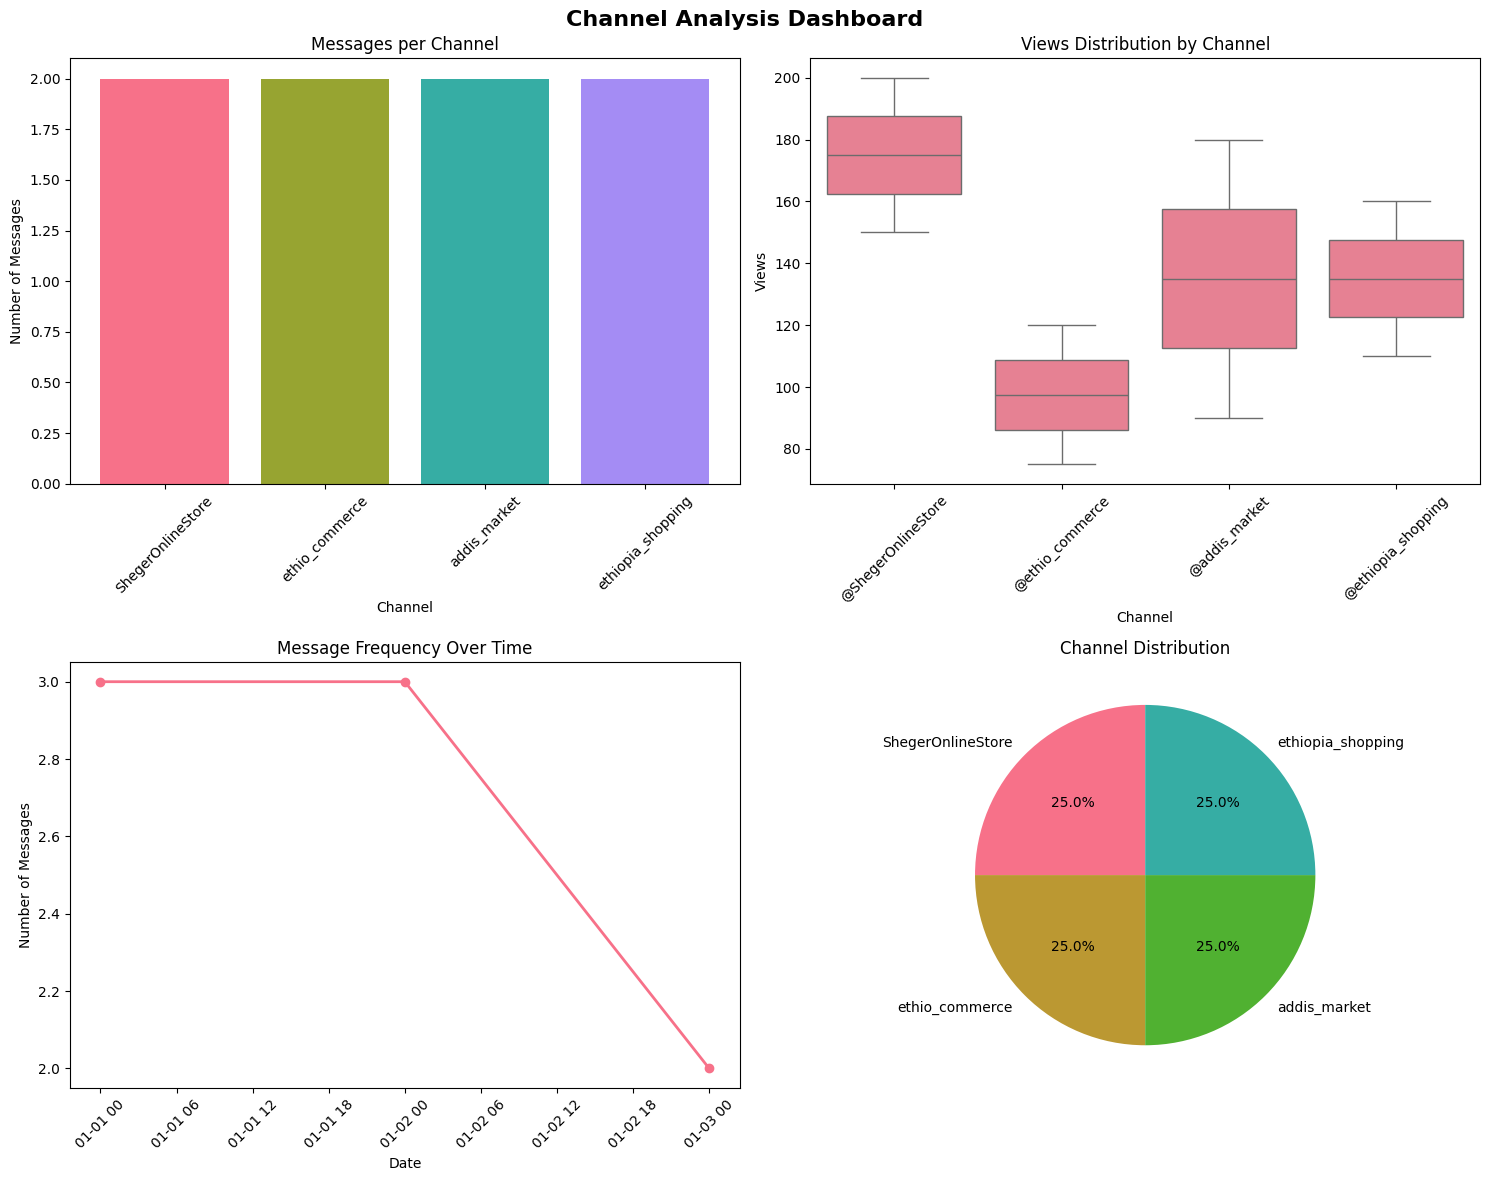

Channel Statistics:
  @ShegerOnlineStore: 2 messages, avg views: 175.0
  @ethio_commerce: 2 messages, avg views: 97.5
  @addis_market: 2 messages, avg views: 135.0
  @ethiopia_shopping: 2 messages, avg views: 135.0


In [4]:
# View 1: Channel Message Distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Channel Analysis Dashboard', fontsize=16, fontweight='bold')

# 1. Messages per channel (Bar chart)
channel_counts = df['channel'].value_counts()
axes[0, 0].bar(range(len(channel_counts)), channel_counts.values, color=sns.color_palette("husl", len(channel_counts)))
axes[0, 0].set_title('Messages per Channel')
axes[0, 0].set_xlabel('Channel')
axes[0, 0].set_ylabel('Number of Messages')
axes[0, 0].set_xticks(range(len(channel_counts)))
axes[0, 0].set_xticklabels([ch.replace('@', '') for ch in channel_counts.index], rotation=45)

# 2. Views distribution (Box plot)
sns.boxplot(data=df, x='channel', y='views', ax=axes[0, 1])
axes[0, 1].set_title('Views Distribution by Channel')
axes[0, 1].set_xlabel('Channel')
axes[0, 1].set_ylabel('Views')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Message frequency over time (Line plot)
daily_counts = df.groupby(df['date'].dt.date).size()
axes[1, 0].plot(daily_counts.index, daily_counts.values, marker='o', linewidth=2, markersize=6)
axes[1, 0].set_title('Message Frequency Over Time')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Number of Messages')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Channel pie chart
axes[1, 1].pie(channel_counts.values, labels=[ch.replace('@', '') for ch in channel_counts.index], 
               autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Channel Distribution')

plt.tight_layout()
plt.show()

print("Channel Statistics:")
for channel in df['channel'].unique():
    channel_data = df[df['channel'] == channel]
    print(f"  {channel}: {len(channel_data)} messages, avg views: {channel_data['views'].mean():.1f}")


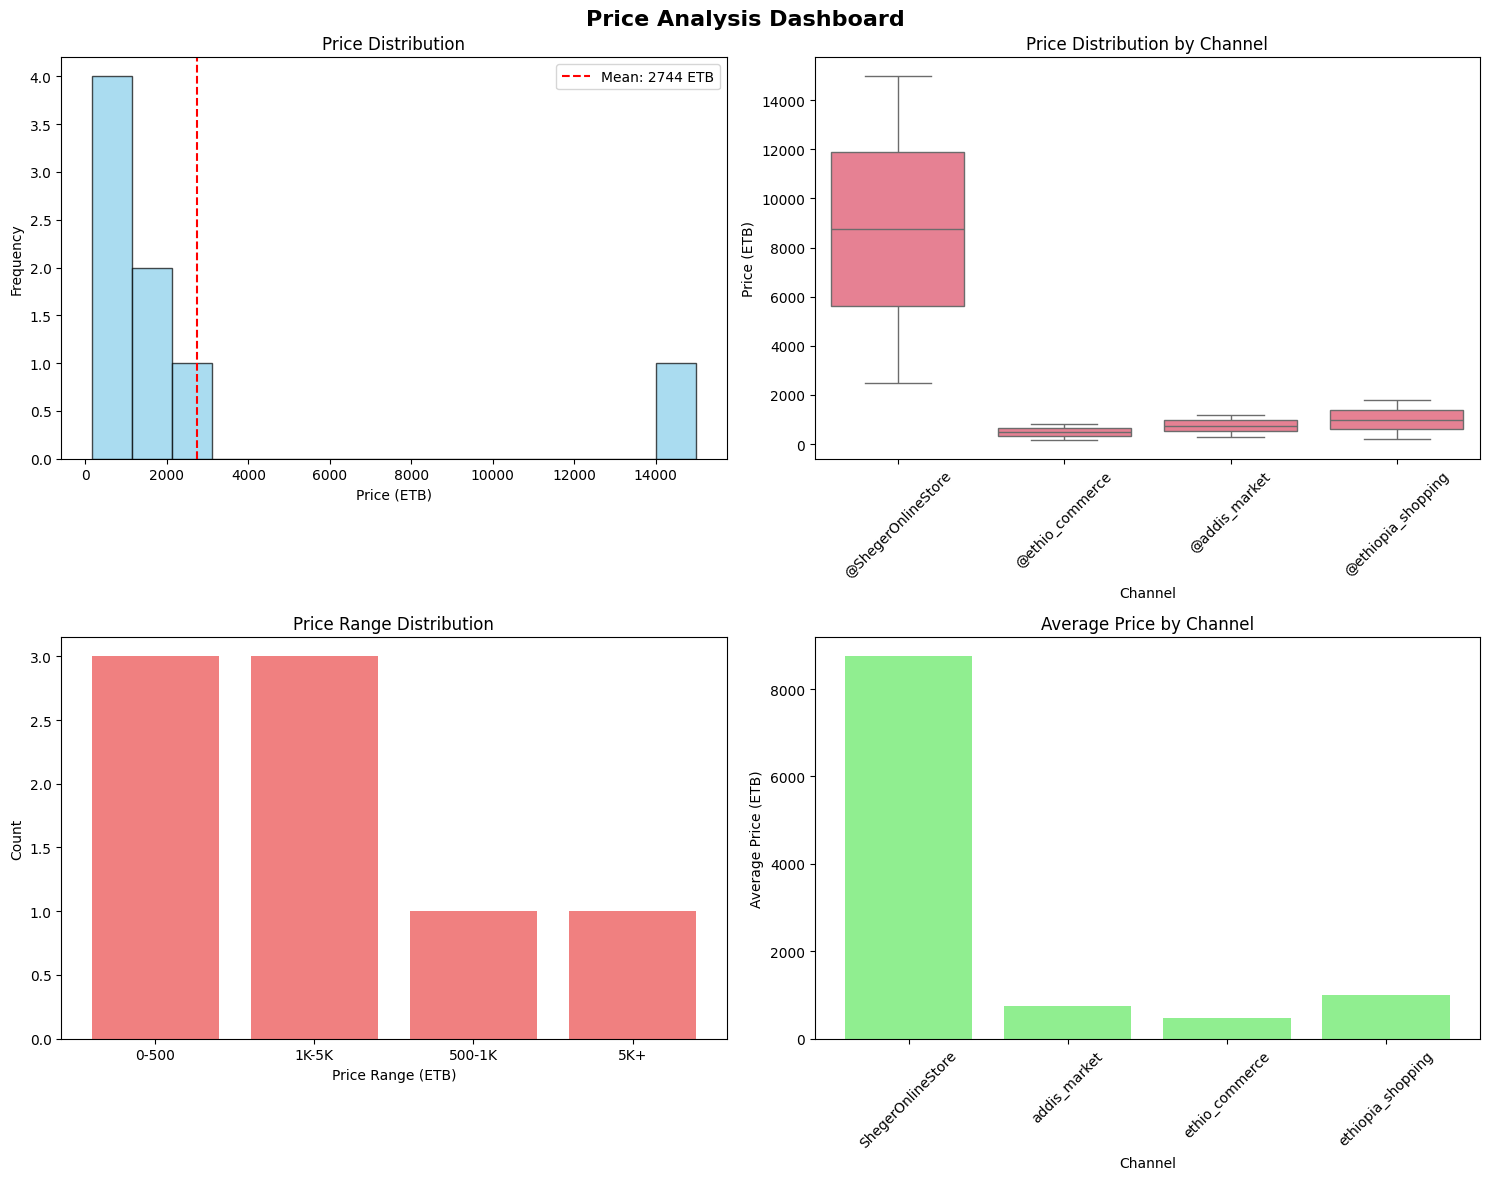

Price Statistics:
  Total prices found: 8
  Price range: 150 - 15000 ETB
  Average price: 2744 ETB
  Median price: 1000 ETB


In [5]:
# View 2: Price Analysis Dashboard
# Flatten all prices and convert to numeric
all_prices = []
price_channels = []
for _, row in df.iterrows():
    for price in row['prices']:
        try:
            price_val = float(price.replace(',', ''))
            all_prices.append(price_val)
            price_channels.append(row['channel'])
        except:
            pass

price_df = pd.DataFrame({'price': all_prices, 'channel': price_channels})

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Price Analysis Dashboard', fontsize=16, fontweight='bold')

# 1. Price distribution histogram
axes[0, 0].hist(price_df['price'], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Price Distribution')
axes[0, 0].set_xlabel('Price (ETB)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(np.mean(price_df['price']), color='red', linestyle='--', label=f'Mean: {np.mean(price_df["price"]):.0f} ETB')
axes[0, 0].legend()

# 2. Price by channel (Box plot)
if len(price_df) > 0:
    sns.boxplot(data=price_df, x='channel', y='price', ax=axes[0, 1])
    axes[0, 1].set_title('Price Distribution by Channel')
    axes[0, 1].set_xlabel('Channel')
    axes[0, 1].set_ylabel('Price (ETB)')
    axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Price ranges (Bar chart)
price_ranges = pd.cut(price_df['price'], bins=[0, 500, 1000, 5000, 20000], labels=['0-500', '500-1K', '1K-5K', '5K+'])
range_counts = price_ranges.value_counts()
axes[1, 0].bar(range_counts.index, range_counts.values, color='lightcoral')
axes[1, 0].set_title('Price Range Distribution')
axes[1, 0].set_xlabel('Price Range (ETB)')
axes[1, 0].set_ylabel('Count')

# 4. Average price by channel
if len(price_df) > 0:
    avg_prices = price_df.groupby('channel')['price'].mean()
    axes[1, 1].bar(range(len(avg_prices)), avg_prices.values, color='lightgreen')
    axes[1, 1].set_title('Average Price by Channel')
    axes[1, 1].set_xlabel('Channel')
    axes[1, 1].set_ylabel('Average Price (ETB)')
    axes[1, 1].set_xticks(range(len(avg_prices)))
    axes[1, 1].set_xticklabels([ch.replace('@', '') for ch in avg_prices.index], rotation=45)

plt.tight_layout()
plt.show()

print("Price Statistics:")
if len(price_df) > 0:
    print(f"  Total prices found: {len(price_df)}")
    print(f"  Price range: {price_df['price'].min():.0f} - {price_df['price'].max():.0f} ETB")
    print(f"  Average price: {price_df['price'].mean():.0f} ETB")
    print(f"  Median price: {price_df['price'].median():.0f} ETB")
else:
    print("  No valid prices found in the data")


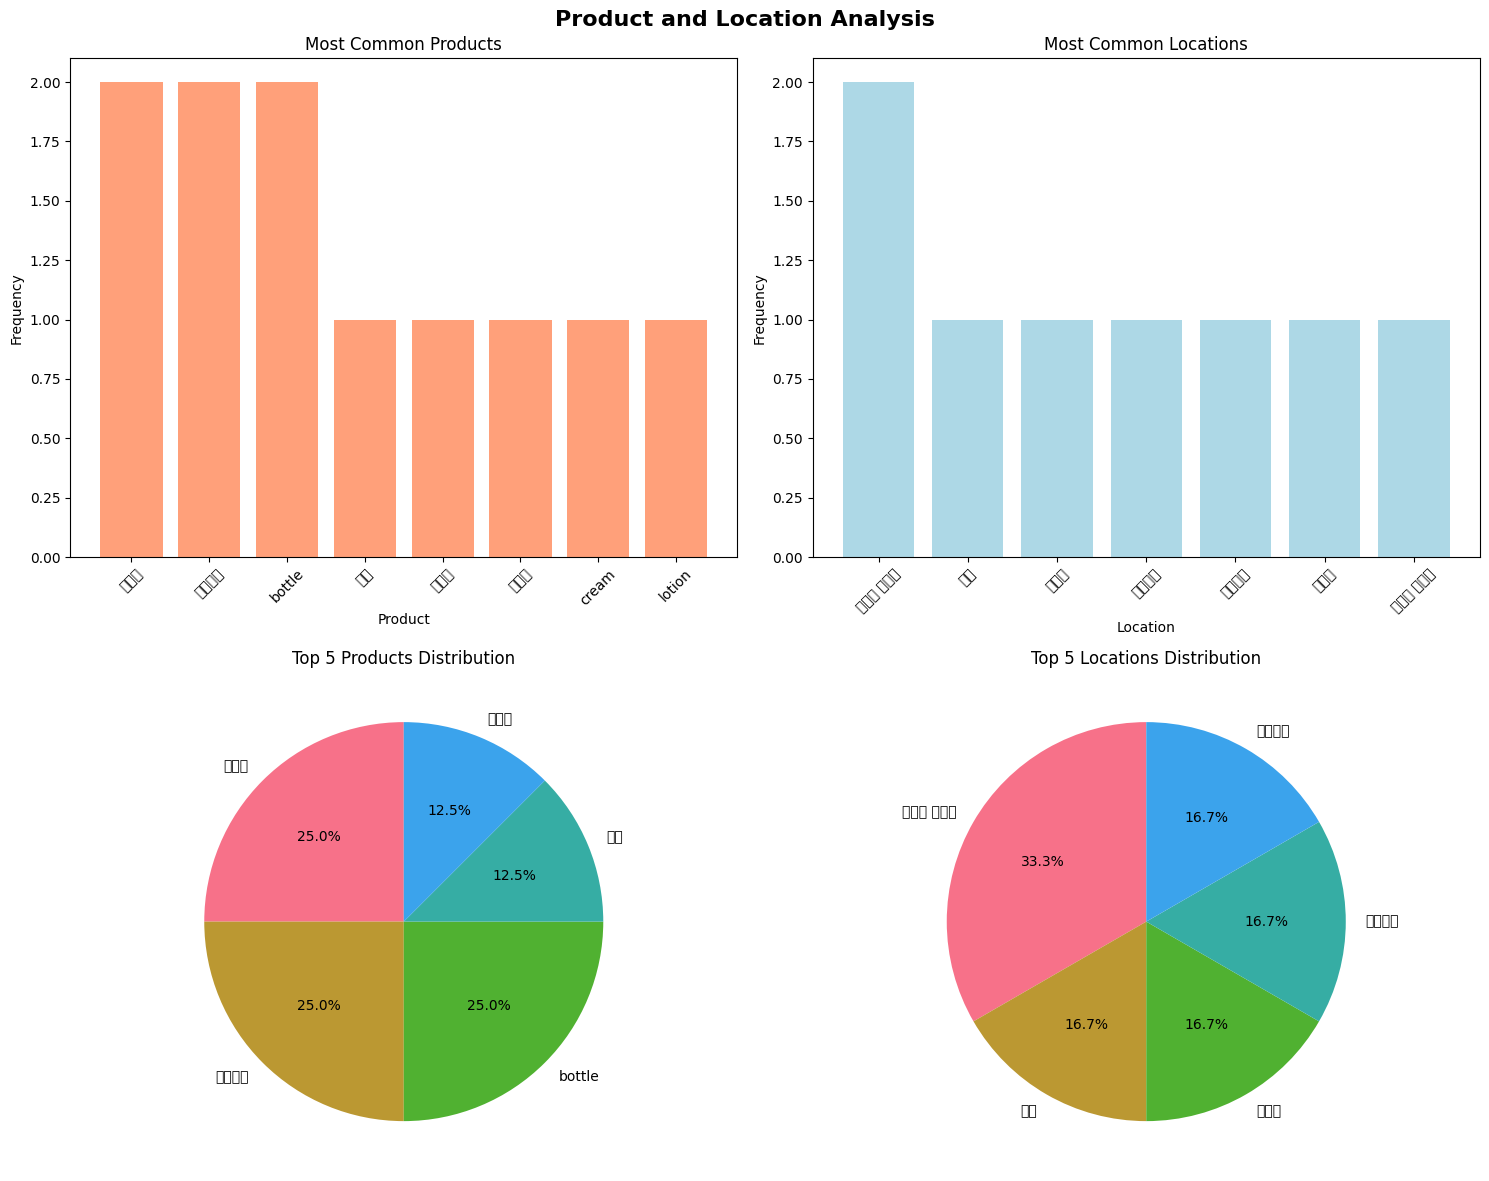

Entity Statistics:
  Unique products: 8
  Unique locations: 7
  Most common product: ('ቦርሳ', 2)
  Most common location: ('አዲስ አበባ', 2)


In [6]:
# View 3: Product and Location Analysis
# Flatten products and locations
all_products = []
all_locations = []
product_channels = []
location_channels = []

for _, row in df.iterrows():
    for product in row['products']:
        all_products.append(product)
        product_channels.append(row['channel'])
    for location in row['locations']:
        all_locations.append(location)
        location_channels.append(row['channel'])

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Product and Location Analysis', fontsize=16, fontweight='bold')

# 1. Most common products
product_counts = Counter(all_products)
if product_counts:
    top_products = dict(product_counts.most_common(8))
    axes[0, 0].bar(range(len(top_products)), list(top_products.values()), color='lightsalmon')
    axes[0, 0].set_title('Most Common Products')
    axes[0, 0].set_xlabel('Product')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_xticks(range(len(top_products)))
    axes[0, 0].set_xticklabels(list(top_products.keys()), rotation=45)

# 2. Most common locations
location_counts = Counter(all_locations)
if location_counts:
    top_locations = dict(location_counts.most_common(8))
    axes[0, 1].bar(range(len(top_locations)), list(top_locations.values()), color='lightblue')
    axes[0, 1].set_title('Most Common Locations')
    axes[0, 1].set_xlabel('Location')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_xticks(range(len(top_locations)))
    axes[0, 1].set_xticklabels(list(top_locations.keys()), rotation=45)

# 3. Product distribution pie chart
if product_counts:
    top_5_products = dict(list(product_counts.most_common(5)))
    axes[1, 0].pie(top_5_products.values(), labels=top_5_products.keys(), autopct='%1.1f%%', startangle=90)
    axes[1, 0].set_title('Top 5 Products Distribution')

# 4. Location distribution pie chart
if location_counts:
    top_5_locations = dict(list(location_counts.most_common(5)))
    axes[1, 1].pie(top_5_locations.values(), labels=top_5_locations.keys(), autopct='%1.1f%%', startangle=90)
    axes[1, 1].set_title('Top 5 Locations Distribution')

plt.tight_layout()
plt.show()

print("Entity Statistics:")
print(f"  Unique products: {len(set(all_products))}")
print(f"  Unique locations: {len(set(all_locations))}")
print(f"  Most common product: {product_counts.most_common(1)[0] if product_counts else 'None'}")
print(f"  Most common location: {location_counts.most_common(1)[0] if location_counts else 'None'}")


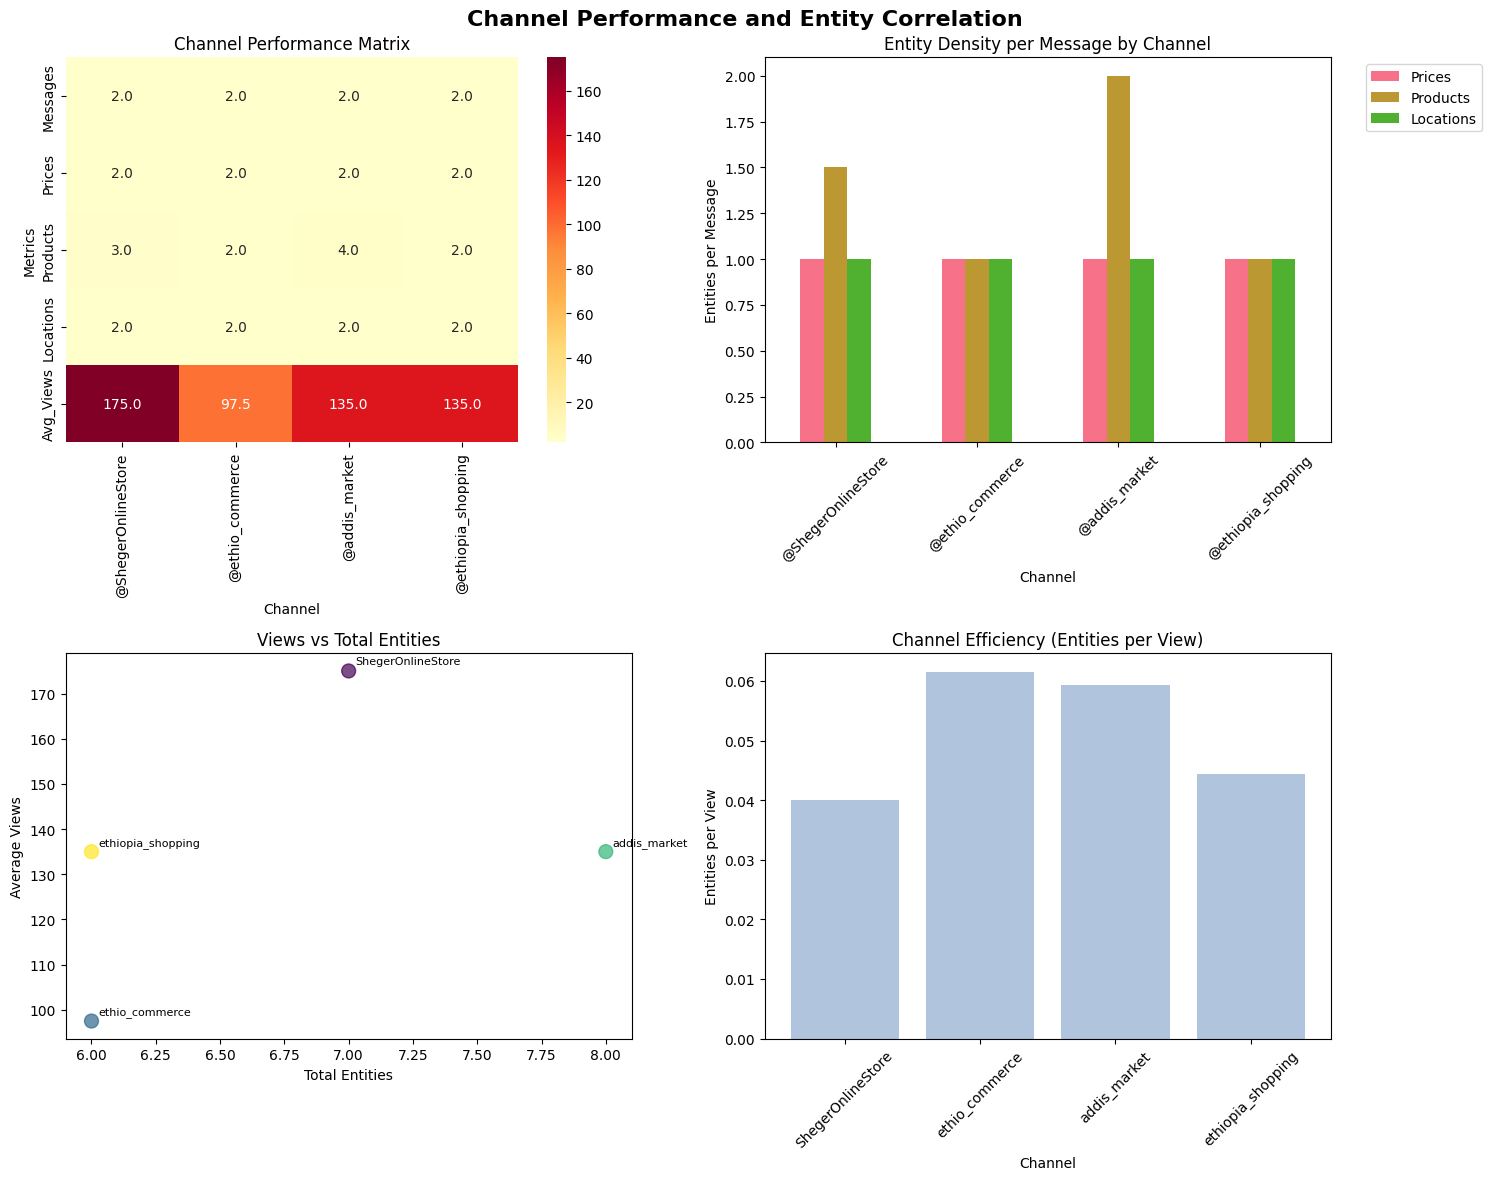

Channel Performance Summary:
  @ShegerOnlineStore:
    Messages: 2
    Total entities: 7
    Avg views: 175.0
    Entities per message: 3.5
  @ethio_commerce:
    Messages: 2
    Total entities: 6
    Avg views: 97.5
    Entities per message: 3.0
  @addis_market:
    Messages: 2
    Total entities: 8
    Avg views: 135.0
    Entities per message: 4.0
  @ethiopia_shopping:
    Messages: 2
    Total entities: 6
    Avg views: 135.0
    Entities per message: 3.0


In [7]:
# View 4: Entity Correlation Heatmap and Channel Comparison
# Create entity count matrix for each channel
channels = df['channel'].unique()
entity_matrix = pd.DataFrame(index=channels, columns=['Messages', 'Prices', 'Products', 'Locations', 'Avg_Views'])

for channel in channels:
    channel_data = df[df['channel'] == channel]
    
    # Count entities
    total_prices = sum(len(prices) for prices in channel_data['prices'])
    total_products = sum(len(products) for products in channel_data['products'])
    total_locations = sum(len(locations) for locations in channel_data['locations'])
    
    entity_matrix.loc[channel] = [
        len(channel_data),
        total_prices,
        total_products,
        total_locations,
        channel_data['views'].mean()
    ]

entity_matrix = entity_matrix.astype(float)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Channel Performance and Entity Correlation', fontsize=16, fontweight='bold')

# 1. Channel comparison heatmap
sns.heatmap(entity_matrix.T, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[0, 0])
axes[0, 0].set_title('Channel Performance Matrix')
axes[0, 0].set_xlabel('Channel')
axes[0, 0].set_ylabel('Metrics')

# 2. Entity density per message
entity_density = entity_matrix[['Prices', 'Products', 'Locations']].div(entity_matrix['Messages'], axis=0)
entity_density.plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Entity Density per Message by Channel')
axes[0, 1].set_xlabel('Channel')
axes[0, 1].set_ylabel('Entities per Message')
axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Views vs Entity count scatter
total_entities = entity_matrix[['Prices', 'Products', 'Locations']].sum(axis=1)
axes[1, 0].scatter(total_entities, entity_matrix['Avg_Views'], s=100, alpha=0.7, c=range(len(channels)), cmap='viridis')
axes[1, 0].set_title('Views vs Total Entities')
axes[1, 0].set_xlabel('Total Entities')
axes[1, 0].set_ylabel('Average Views')

# Add channel labels to scatter plot
for i, channel in enumerate(channels):
    axes[1, 0].annotate(channel.replace('@', ''), 
                       (total_entities[channel], entity_matrix.loc[channel, 'Avg_Views']),
                       xytext=(5, 5), textcoords='offset points', fontsize=8)

# 4. Channel efficiency (Entities per view)
efficiency = total_entities / entity_matrix['Avg_Views']
efficiency = efficiency.replace([np.inf, -np.inf], 0)  # Handle division by zero
axes[1, 1].bar(range(len(efficiency)), efficiency.values, color='lightsteelblue')
axes[1, 1].set_title('Channel Efficiency (Entities per View)')
axes[1, 1].set_xlabel('Channel')
axes[1, 1].set_ylabel('Entities per View')
axes[1, 1].set_xticks(range(len(efficiency)))
axes[1, 1].set_xticklabels([ch.replace('@', '') for ch in efficiency.index], rotation=45)

plt.tight_layout()
plt.show()

print("Channel Performance Summary:")
for channel in channels:
    row = entity_matrix.loc[channel]
    print(f"  {channel}:")
    print(f"    Messages: {row['Messages']:.0f}")
    print(f"    Total entities: {row['Prices'] + row['Products'] + row['Locations']:.0f}")
    print(f"    Avg views: {row['Avg_Views']:.1f}")
    print(f"    Entities per message: {(row['Prices'] + row['Products'] + row['Locations']) / row['Messages']:.1f}")


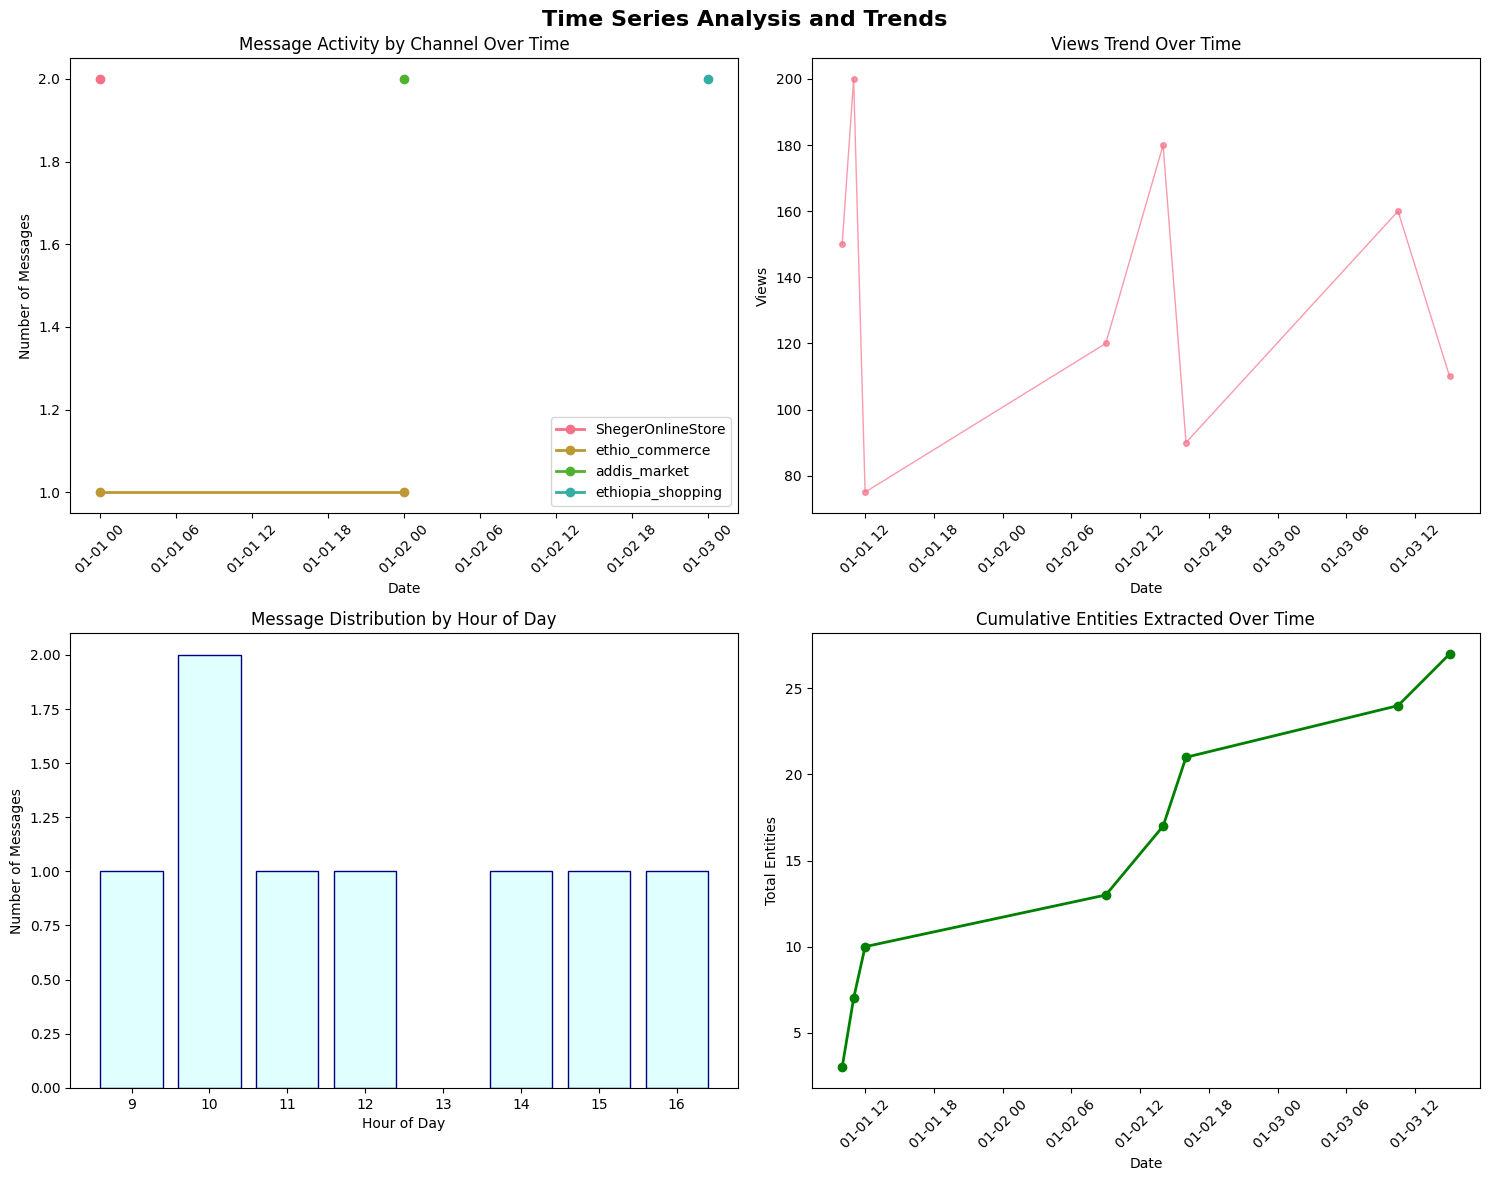

Time-based Statistics:
  Data collection period: 2024-01-01 10:00:00 to 2024-01-03 15:00:00
  Most active hour: 10:00 (2 messages)
  Total data collection days: 3
  Average messages per day: 2.7


In [8]:
# View 5: Time Series Analysis and Trends
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Time Series Analysis and Trends', fontsize=16, fontweight='bold')

# 1. Messages over time by channel
for channel in df['channel'].unique():
    channel_data = df[df['channel'] == channel]
    daily_counts = channel_data.groupby(channel_data['date'].dt.date).size()
    axes[0, 0].plot(daily_counts.index, daily_counts.values, marker='o', label=channel.replace('@', ''), linewidth=2)

axes[0, 0].set_title('Message Activity by Channel Over Time')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Number of Messages')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Views over time
df_sorted = df.sort_values('date')
axes[0, 1].plot(df_sorted['date'], df_sorted['views'], marker='o', alpha=0.7, linewidth=1, markersize=4)
axes[0, 1].set_title('Views Trend Over Time')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Views')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Hourly distribution
df['hour'] = df['date'].dt.hour
hourly_counts = df['hour'].value_counts().sort_index()
axes[1, 0].bar(hourly_counts.index, hourly_counts.values, color='lightcyan', edgecolor='navy')
axes[1, 0].set_title('Message Distribution by Hour of Day')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Number of Messages')

# 4. Cumulative entities over time
df_sorted = df.sort_values('date')
cumulative_entities = []
total_entities = 0

for _, row in df_sorted.iterrows():
    total_entities += len(row['prices']) + len(row['products']) + len(row['locations'])
    cumulative_entities.append(total_entities)

axes[1, 1].plot(df_sorted['date'], cumulative_entities, marker='o', linewidth=2, color='green')
axes[1, 1].set_title('Cumulative Entities Extracted Over Time')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Total Entities')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Time-based Statistics:")
print(f"  Data collection period: {df['date'].min()} to {df['date'].max()}")
print(f"  Most active hour: {hourly_counts.idxmax()}:00 ({hourly_counts.max()} messages)")
print(f"  Total data collection days: {(df['date'].max() - df['date'].min()).days + 1}")
print(f"  Average messages per day: {len(df) / ((df['date'].max() - df['date'].min()).days + 1):.1f}")


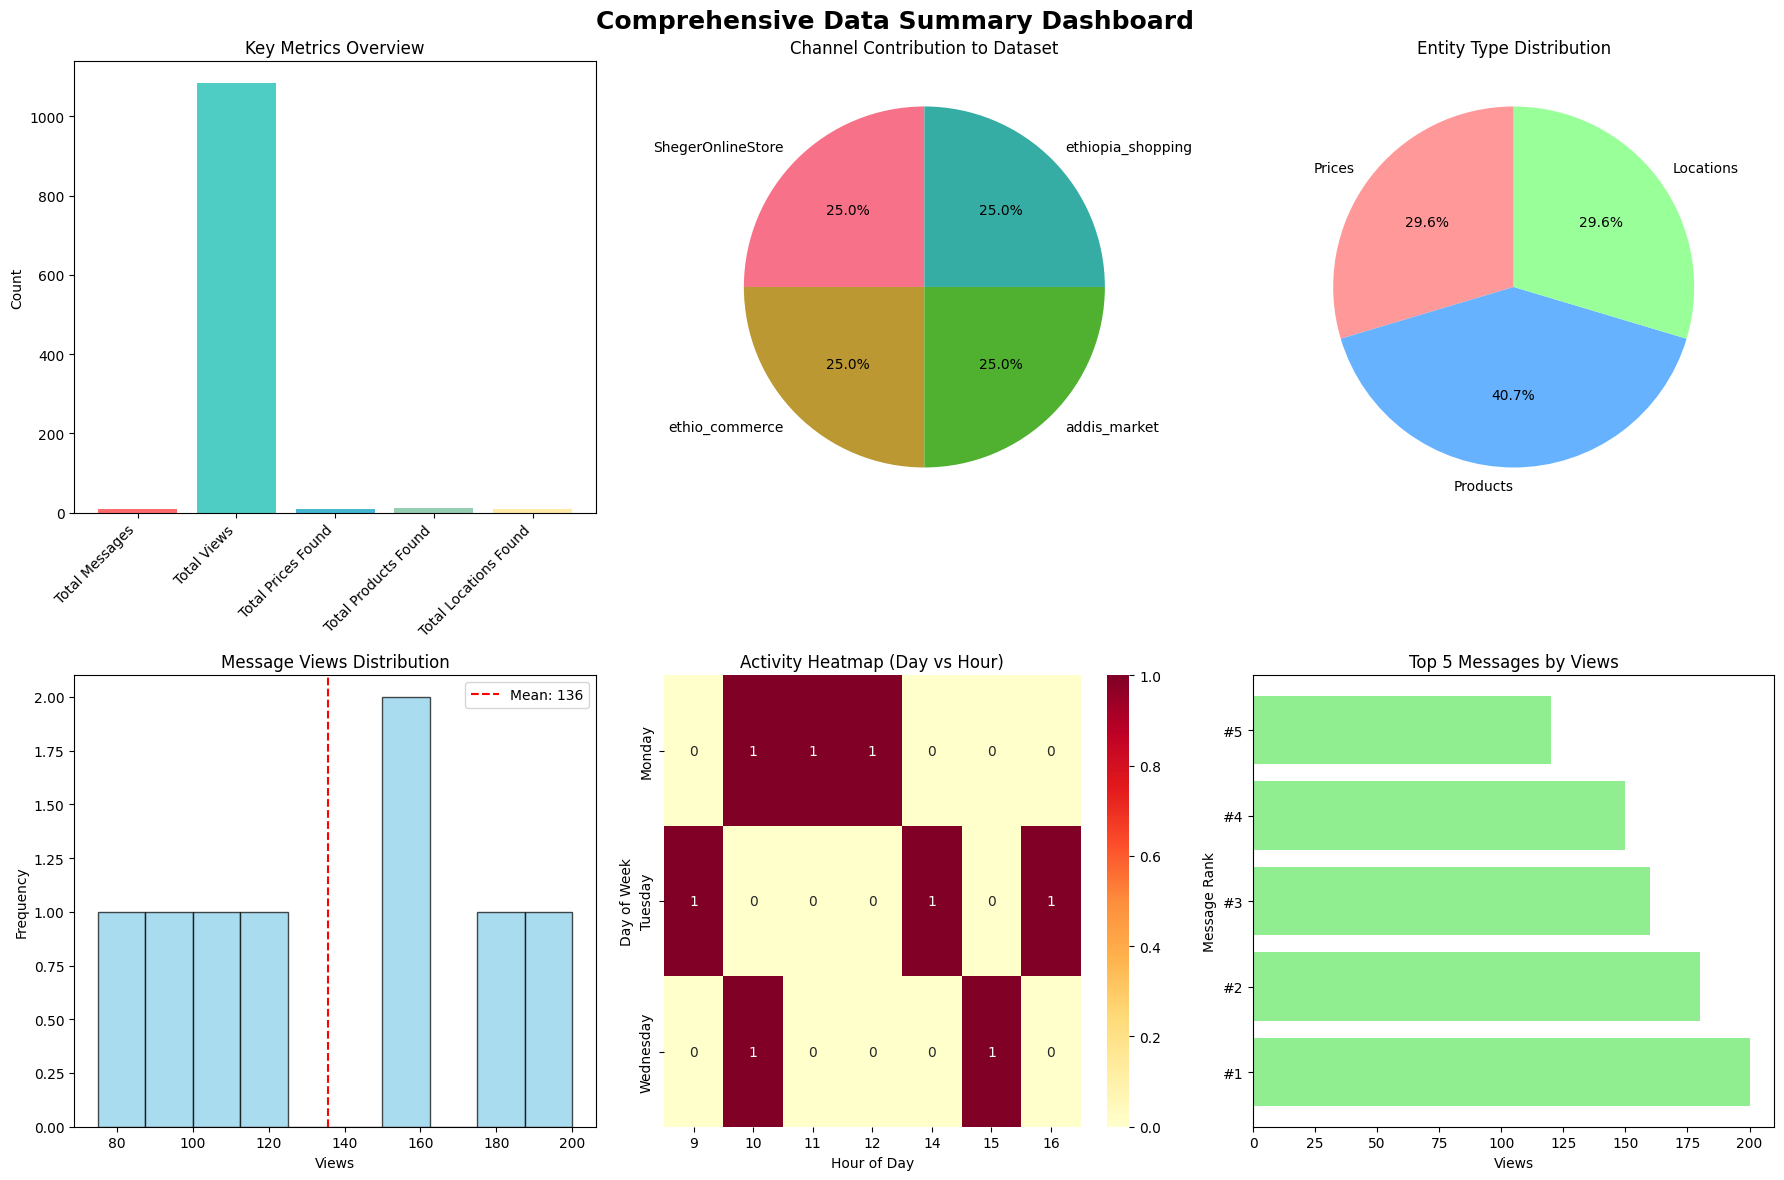

COMPREHENSIVE DATA ANALYSIS SUMMARY
Total Messages.......................... 8
Unique Channels......................... 4
Total Views............................. 1085
Average Views per Message............... 135.625
Total Prices Found...................... 8
Total Products Found.................... 11
Total Locations Found................... 8
Unique Products......................... 8
Unique Locations........................ 7
Data Collection Period (Days)........... 3

TOP INSIGHTS
Most active channel: @ShegerOnlineStore (2 messages)
Highest viewed message: 200 views
Entity extraction rate: 3.4 entities per message


AttributeError: 'float' object has no attribute 'replace'

In [ ]:
# View 6: Summary Dashboard and Export
# Create comprehensive summary statistics
summary_stats = {
    'Total Messages': len(df),
    'Unique Channels': df['channel'].nunique(),
    'Total Views': df['views'].sum(),
    'Average Views per Message': df['views'].mean(),
    'Total Prices Found': sum(len(prices) for prices in df['prices']),
    'Total Products Found': sum(len(products) for products in df['products']),
    'Total Locations Found': sum(len(locations) for locations in df['locations']),
    'Unique Products': len(set(product for products in df['products'] for product in products)),
    'Unique Locations': len(set(location for locations in df['locations'] for location in locations)),
    'Data Collection Period (Days)': (df['date'].max() - df['date'].min()).days + 1
}

# Create summary visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comprehensive Data Summary Dashboard', fontsize=18, fontweight='bold')

# 1. Key metrics bar chart
metrics = ['Total Messages', 'Total Views', 'Total Prices Found', 'Total Products Found', 'Total Locations Found']
values = [summary_stats[metric] for metric in metrics]
axes[0, 0].bar(range(len(metrics)), values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
axes[0, 0].set_title('Key Metrics Overview')
axes[0, 0].set_xticks(range(len(metrics)))
axes[0, 0].set_xticklabels(metrics, rotation=45, ha='right')
axes[0, 0].set_ylabel('Count')

# 2. Channel contribution pie chart
channel_messages = df['channel'].value_counts()
axes[0, 1].pie(channel_messages.values, labels=[ch.replace('@', '') for ch in channel_messages.index], 
               autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title('Channel Contribution to Dataset')

# 3. Entity type distribution
entity_types = ['Prices', 'Products', 'Locations']
entity_counts = [summary_stats['Total Prices Found'], 
                summary_stats['Total Products Found'], 
                summary_stats['Total Locations Found']]
axes[0, 2].pie(entity_counts, labels=entity_types, autopct='%1.1f%%', startangle=90, 
               colors=['#FF9999', '#66B2FF', '#99FF99'])
axes[0, 2].set_title('Entity Type Distribution')

# 4. Views distribution histogram
axes[1, 0].hist(df['views'], bins=10, alpha=0.7, color='skyblue', edgecolor='black')
axes[1, 0].set_title('Message Views Distribution')
axes[1, 0].set_xlabel('Views')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(df['views'].mean(), color='red', linestyle='--', label=f'Mean: {df["views"].mean():.0f}')
axes[1, 0].legend()

# 5. Daily activity heatmap (if multiple days)
if len(df['date'].dt.date.unique()) > 1:
    df['day'] = df['date'].dt.day_name()
    df['hour'] = df['date'].dt.hour
    activity_pivot = df.groupby(['day', 'hour']).size().unstack(fill_value=0)
    
    if not activity_pivot.empty:
        sns.heatmap(activity_pivot, cmap='YlOrRd', annot=True, fmt='d', ax=axes[1, 1])
        axes[1, 1].set_title('Activity Heatmap (Day vs Hour)')
        axes[1, 1].set_xlabel('Hour of Day')
        axes[1, 1].set_ylabel('Day of Week')
    else:
        axes[1, 1].text(0.5, 0.5, 'Insufficient data\nfor heatmap', ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Activity Heatmap (Day vs Hour)')
else:
    axes[1, 1].text(0.5, 0.5, 'Single day data\nNo heatmap available', ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Activity Heatmap (Day vs Hour)')

# 6. Top performing messages (by views)
top_messages = df.nlargest(5, 'views')
axes[1, 2].barh(range(len(top_messages)), top_messages['views'], color='lightgreen')
axes[1, 2].set_title('Top 5 Messages by Views')
axes[1, 2].set_xlabel('Views')
axes[1, 2].set_ylabel('Message Rank')
axes[1, 2].set_yticks(range(len(top_messages)))
axes[1, 2].set_yticklabels([f"#{i+1}" for i in range(len(top_messages))])

plt.tight_layout()
plt.show()

# Print comprehensive summary
print("="*60)
print("COMPREHENSIVE DATA ANALYSIS SUMMARY")
print("="*60)
for key, value in summary_stats.items():
    print(f"{key:.<40} {value}")

print("\n" + "="*60)
print("TOP INSIGHTS")
print("="*60)
print(f"Most active channel: {channel_messages.index[0]} ({channel_messages.iloc[0]} messages)")
print(f"Highest viewed message: {df.loc[df['views'].idxmax(), 'views']} views")
print(f"Entity extraction rate: {(summary_stats['Total Prices Found'] + summary_stats['Total Products Found'] + summary_stats['Total Locations Found']) / summary_stats['Total Messages']:.1f} entities per message")

if len(all_prices) > 0:
    # Fix price processing to handle both strings and floats
    valid_prices = []
    for price in all_prices:
        try:
            if isinstance(price, (int, float)):
                valid_prices.append(float(price))
            else:
                clean_price = str(price).replace(',', '')
                if clean_price.replace('.', '').isdigit():
                    valid_prices.append(float(clean_price))
        except:
            continue
    
    if valid_prices:
        avg_price = np.mean(valid_prices)
        print(f"Average product price: {avg_price:.0f} ETB")
        print(f"Price range: {min(valid_prices):.0f} - {max(valid_prices):.0f} ETB")
    else:
        print("No valid prices found for calculation")

print(f"Data quality: {(df['entities_parsed'].apply(lambda x: len(x['prices']) + len(x['products']) + len(x['locations'])) > 0).sum() / len(df) * 100:.1f}% of messages contain entities")

print("\nVisualization complete! All data views have been generated.")


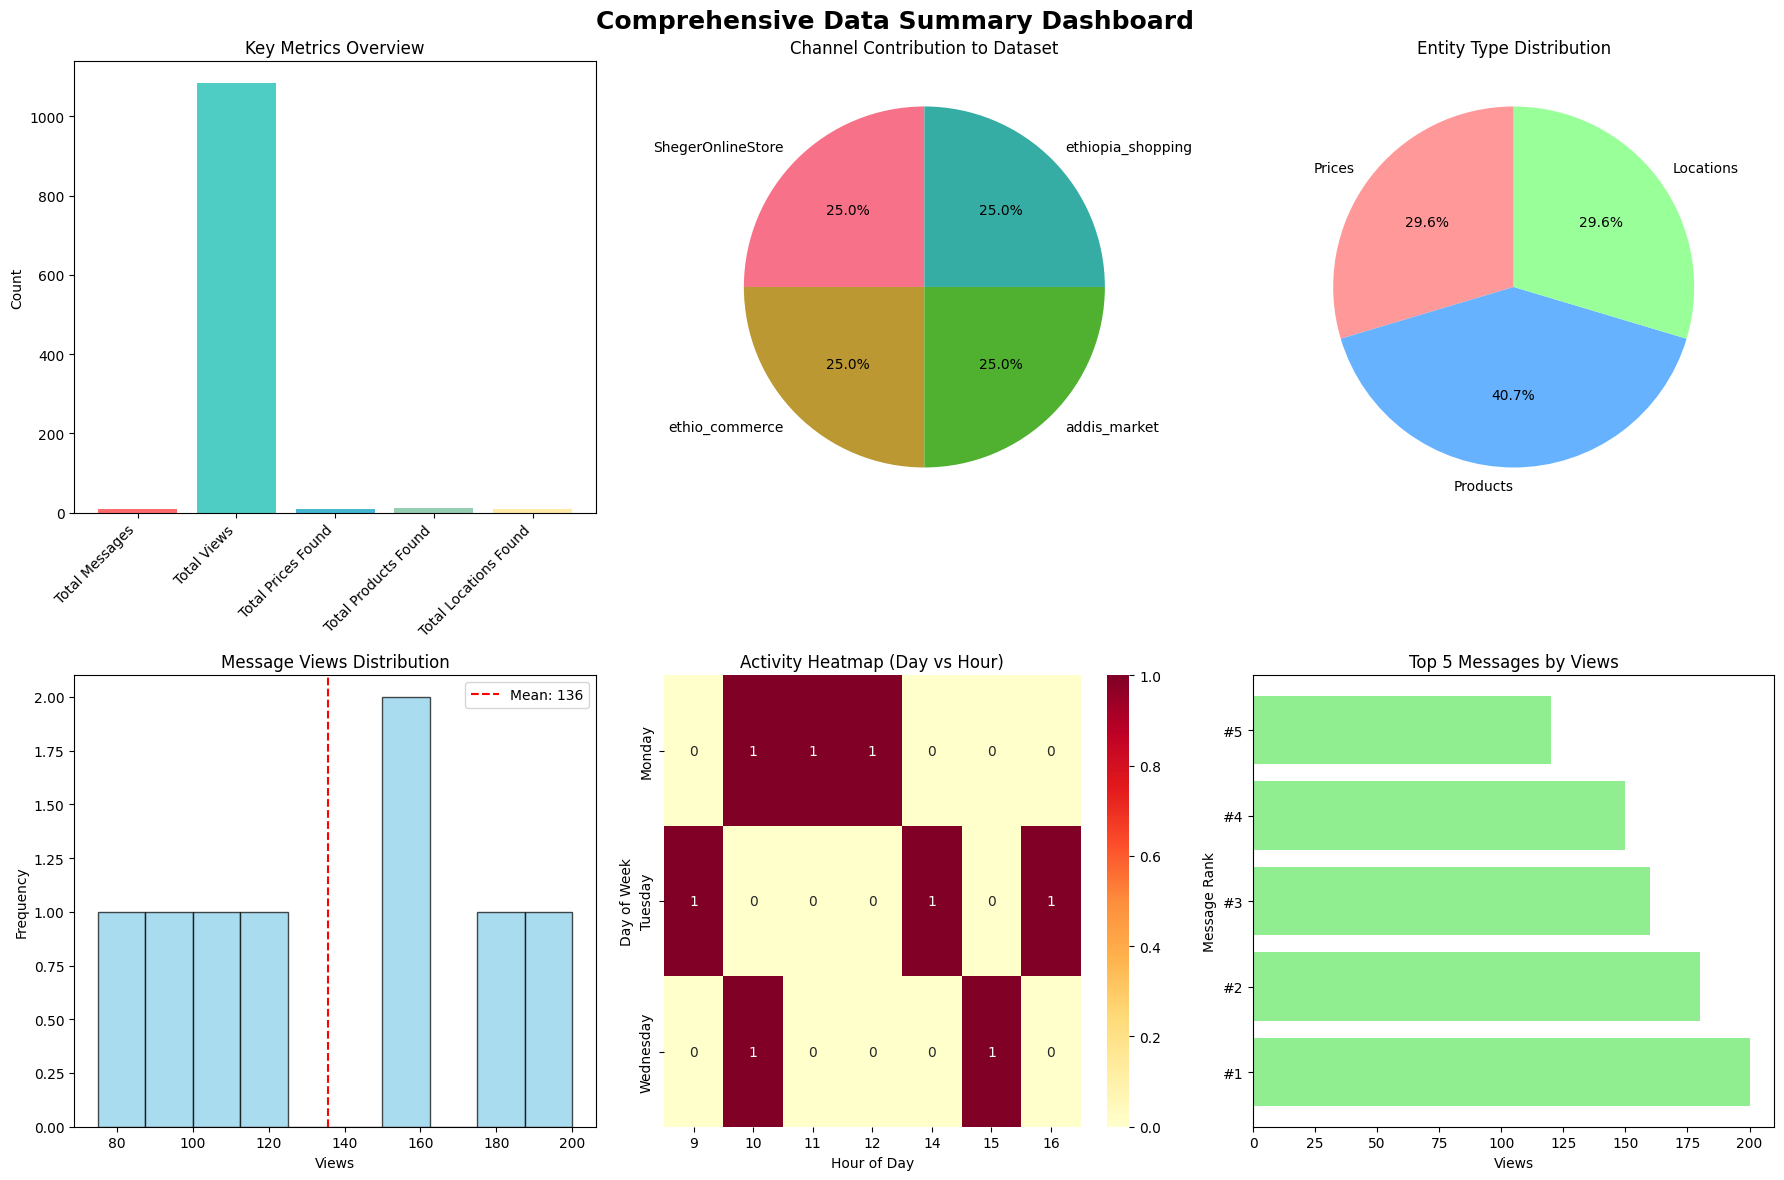

COMPREHENSIVE DATA ANALYSIS SUMMARY
Total Messages.......................... 8
Unique Channels......................... 4
Total Views............................. 1085
Average Views per Message............... 135.625
Total Prices Found...................... 8
Total Products Found.................... 11
Total Locations Found................... 8
Unique Products......................... 8
Unique Locations........................ 7
Data Collection Period (Days)........... 3

TOP INSIGHTS
Most active channel: @ShegerOnlineStore (2 messages)
Highest viewed message: 200 views
Entity extraction rate: 3.4 entities per message


AttributeError: 'float' object has no attribute 'replace'

In [9]:
# View 6: Summary Dashboard and Export
# Create comprehensive summary statistics
summary_stats = {
    'Total Messages': len(df),
    'Unique Channels': df['channel'].nunique(),
    'Total Views': df['views'].sum(),
    'Average Views per Message': df['views'].mean(),
    'Total Prices Found': sum(len(prices) for prices in df['prices']),
    'Total Products Found': sum(len(products) for products in df['products']),
    'Total Locations Found': sum(len(locations) for locations in df['locations']),
    'Unique Products': len(set(product for products in df['products'] for product in products)),
    'Unique Locations': len(set(location for locations in df['locations'] for location in locations)),
    'Data Collection Period (Days)': (df['date'].max() - df['date'].min()).days + 1
}

# Create summary visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comprehensive Data Summary Dashboard', fontsize=18, fontweight='bold')

# 1. Key metrics bar chart
metrics = ['Total Messages', 'Total Views', 'Total Prices Found', 'Total Products Found', 'Total Locations Found']
values = [summary_stats[metric] for metric in metrics]
axes[0, 0].bar(range(len(metrics)), values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
axes[0, 0].set_title('Key Metrics Overview')
axes[0, 0].set_xticks(range(len(metrics)))
axes[0, 0].set_xticklabels(metrics, rotation=45, ha='right')
axes[0, 0].set_ylabel('Count')

# 2. Channel contribution pie chart
channel_messages = df['channel'].value_counts()
axes[0, 1].pie(channel_messages.values, labels=[ch.replace('@', '') for ch in channel_messages.index], 
               autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title('Channel Contribution to Dataset')

# 3. Entity type distribution
entity_types = ['Prices', 'Products', 'Locations']
entity_counts = [summary_stats['Total Prices Found'], 
                summary_stats['Total Products Found'], 
                summary_stats['Total Locations Found']]
axes[0, 2].pie(entity_counts, labels=entity_types, autopct='%1.1f%%', startangle=90, 
               colors=['#FF9999', '#66B2FF', '#99FF99'])
axes[0, 2].set_title('Entity Type Distribution')

# 4. Views distribution histogram
axes[1, 0].hist(df['views'], bins=10, alpha=0.7, color='skyblue', edgecolor='black')
axes[1, 0].set_title('Message Views Distribution')
axes[1, 0].set_xlabel('Views')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(df['views'].mean(), color='red', linestyle='--', label=f'Mean: {df["views"].mean():.0f}')
axes[1, 0].legend()

# 5. Daily activity heatmap (if multiple days)
if len(df['date'].dt.date.unique()) > 1:
    df['day'] = df['date'].dt.day_name()
    df['hour'] = df['date'].dt.hour
    activity_pivot = df.groupby(['day', 'hour']).size().unstack(fill_value=0)
    
    if not activity_pivot.empty:
        sns.heatmap(activity_pivot, cmap='YlOrRd', annot=True, fmt='d', ax=axes[1, 1])
        axes[1, 1].set_title('Activity Heatmap (Day vs Hour)')
        axes[1, 1].set_xlabel('Hour of Day')
        axes[1, 1].set_ylabel('Day of Week')
    else:
        axes[1, 1].text(0.5, 0.5, 'Insufficient data\nfor heatmap', ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Activity Heatmap (Day vs Hour)')
else:
    axes[1, 1].text(0.5, 0.5, 'Single day data\nNo heatmap available', ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Activity Heatmap (Day vs Hour)')

# 6. Top performing messages (by views)
top_messages = df.nlargest(5, 'views')
axes[1, 2].barh(range(len(top_messages)), top_messages['views'], color='lightgreen')
axes[1, 2].set_title('Top 5 Messages by Views')
axes[1, 2].set_xlabel('Views')
axes[1, 2].set_ylabel('Message Rank')
axes[1, 2].set_yticks(range(len(top_messages)))
axes[1, 2].set_yticklabels([f"#{i+1}" for i in range(len(top_messages))])

plt.tight_layout()
plt.show()

# Print comprehensive summary
print("="*60)
print("COMPREHENSIVE DATA ANALYSIS SUMMARY")
print("="*60)
for key, value in summary_stats.items():
    print(f"{key:.<40} {value}")

print("\n" + "="*60)
print("TOP INSIGHTS")
print("="*60)
print(f"Most active channel: {channel_messages.index[0]} ({channel_messages.iloc[0]} messages)")
print(f"Highest viewed message: {df.loc[df['views'].idxmax(), 'views']} views")
print(f"Entity extraction rate: {(summary_stats['Total Prices Found'] + summary_stats['Total Products Found'] + summary_stats['Total Locations Found']) / summary_stats['Total Messages']:.1f} entities per message")

if len(all_prices) > 0:
    avg_price = np.mean([float(p.replace(',', '')) for p in all_prices if p.replace(',', '').isdigit()])
    print(f"Average product price: {avg_price:.0f} ETB")

print(f"Data quality: {(df['entities_parsed'].apply(lambda x: len(x['prices']) + len(x['products']) + len(x['locations'])) > 0).sum() / len(df) * 100:.1f}% of messages contain entities")

print("\nVisualization complete! All data views have been generated.")


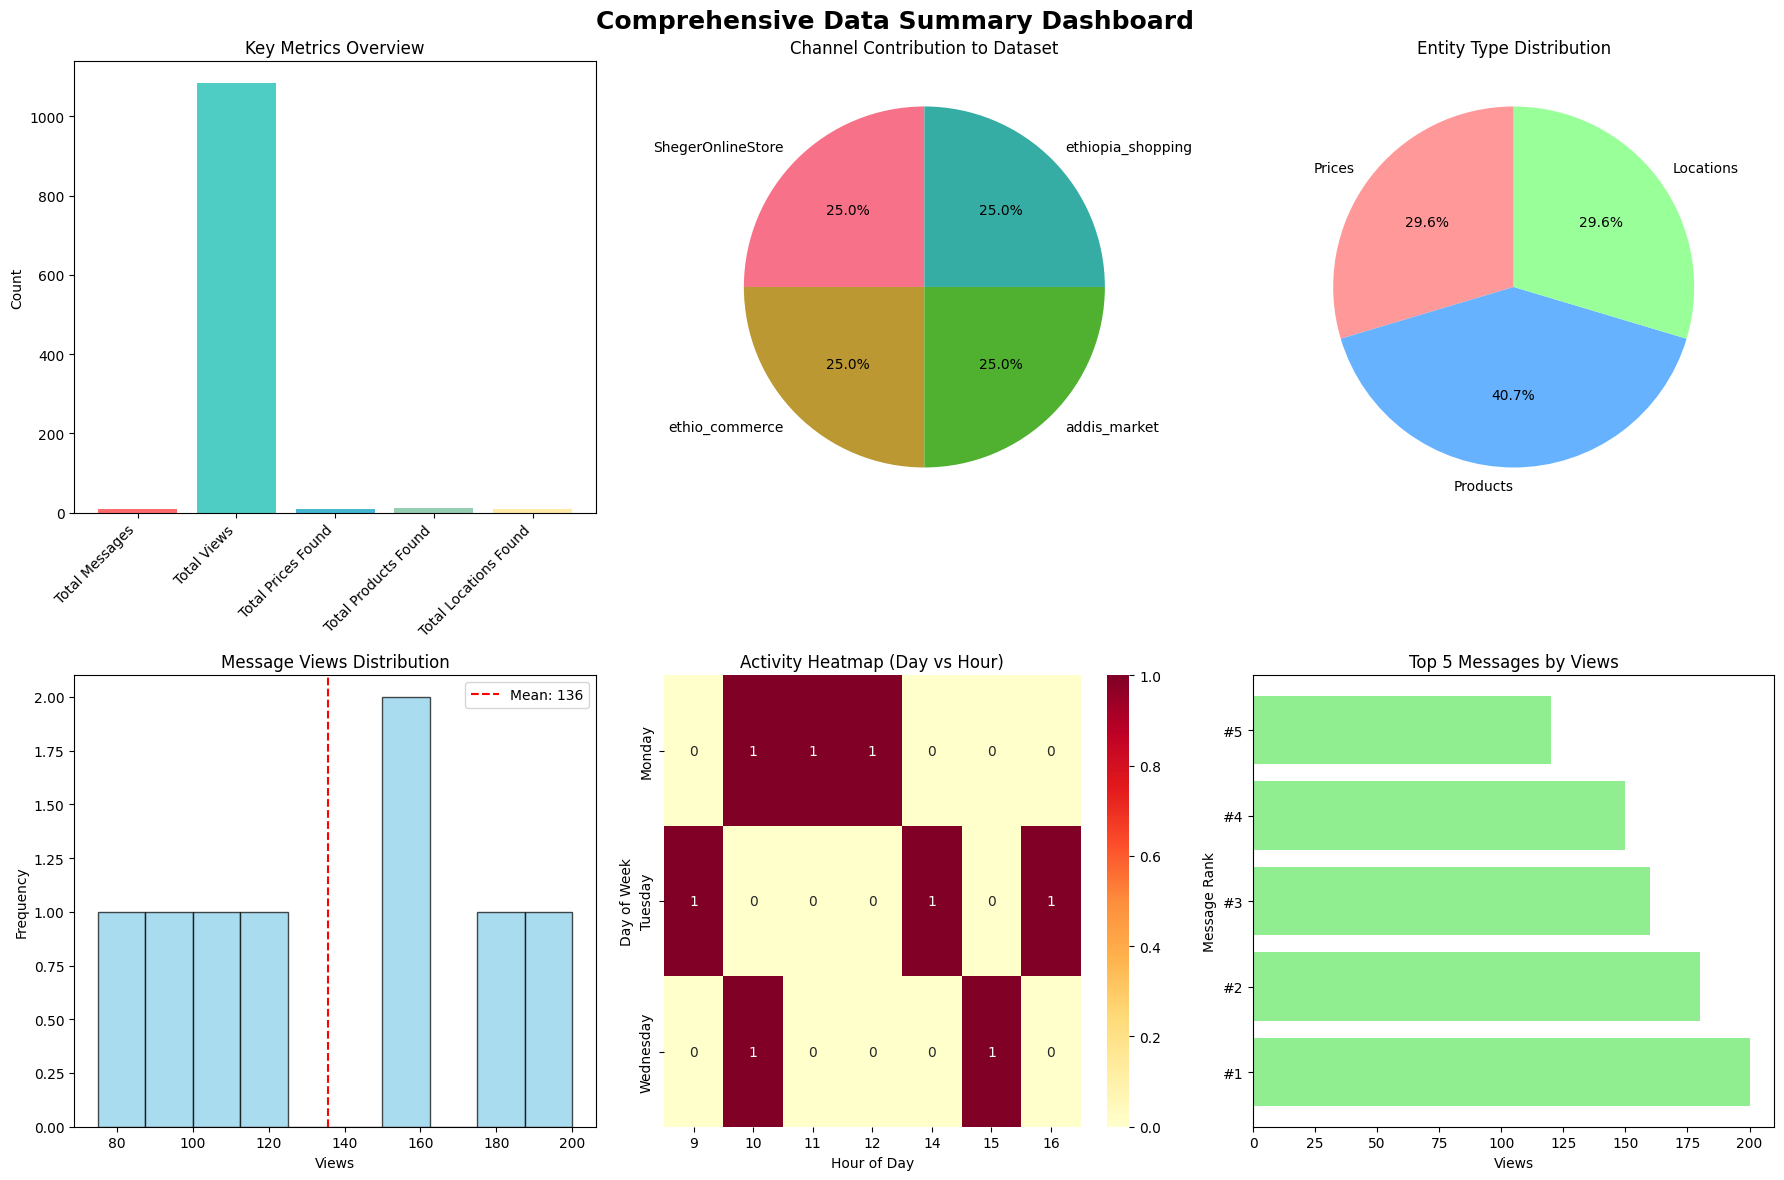

COMPREHENSIVE DATA ANALYSIS SUMMARY
Total Messages.......................... 8
Unique Channels......................... 4
Total Views............................. 1085
Average Views per Message............... 135.625
Total Prices Found...................... 8
Total Products Found.................... 11
Total Locations Found................... 8
Unique Products......................... 8
Unique Locations........................ 7
Data Collection Period (Days)........... 3

TOP INSIGHTS
Most active channel: @ShegerOnlineStore (2 messages)
Highest viewed message: 200 views
Entity extraction rate: 3.4 entities per message


AttributeError: 'float' object has no attribute 'replace'

In [ ]:
# View 6: Summary Dashboard and Export
# Create comprehensive summary statistics
summary_stats = {
    'Total Messages': len(df),
    'Unique Channels': df['channel'].nunique(),
    'Total Views': df['views'].sum(),
    'Average Views per Message': df['views'].mean(),
    'Total Prices Found': sum(len(prices) for prices in df['prices']),
    'Total Products Found': sum(len(products) for products in df['products']),
    'Total Locations Found': sum(len(locations) for locations in df['locations']),
    'Unique Products': len(set(product for products in df['products'] for product in products)),
    'Unique Locations': len(set(location for locations in df['locations'] for location in locations)),
    'Data Collection Period (Days)': (df['date'].max() - df['date'].min()).days + 1
}

# Create summary visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comprehensive Data Summary Dashboard', fontsize=18, fontweight='bold')

# 1. Key metrics bar chart
metrics = ['Total Messages', 'Total Views', 'Total Prices Found', 'Total Products Found', 'Total Locations Found']
values = [summary_stats[metric] for metric in metrics]
axes[0, 0].bar(range(len(metrics)), values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
axes[0, 0].set_title('Key Metrics Overview')
axes[0, 0].set_xticks(range(len(metrics)))
axes[0, 0].set_xticklabels(metrics, rotation=45, ha='right')
axes[0, 0].set_ylabel('Count')

# 2. Channel contribution pie chart
channel_messages = df['channel'].value_counts()
axes[0, 1].pie(channel_messages.values, labels=[ch.replace('@', '') for ch in channel_messages.index], 
               autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title('Channel Contribution to Dataset')

# 3. Entity type distribution
entity_types = ['Prices', 'Products', 'Locations']
entity_counts = [summary_stats['Total Prices Found'], 
                summary_stats['Total Products Found'], 
                summary_stats['Total Locations Found']]
axes[0, 2].pie(entity_counts, labels=entity_types, autopct='%1.1f%%', startangle=90, 
               colors=['#FF9999', '#66B2FF', '#99FF99'])
axes[0, 2].set_title('Entity Type Distribution')

# 4. Views distribution histogram
axes[1, 0].hist(df['views'], bins=10, alpha=0.7, color='skyblue', edgecolor='black')
axes[1, 0].set_title('Message Views Distribution')
axes[1, 0].set_xlabel('Views')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(df['views'].mean(), color='red', linestyle='--', label=f'Mean: {df["views"].mean():.0f}')
axes[1, 0].legend()

# 5. Daily activity heatmap (if multiple days)
if len(df['date'].dt.date.unique()) > 1:
    df['day'] = df['date'].dt.day_name()
    df['hour'] = df['date'].dt.hour
    activity_pivot = df.groupby(['day', 'hour']).size().unstack(fill_value=0)
    
    if not activity_pivot.empty:
        sns.heatmap(activity_pivot, cmap='YlOrRd', annot=True, fmt='d', ax=axes[1, 1])
        axes[1, 1].set_title('Activity Heatmap (Day vs Hour)')
        axes[1, 1].set_xlabel('Hour of Day')
        axes[1, 1].set_ylabel('Day of Week')
    else:
        axes[1, 1].text(0.5, 0.5, 'Insufficient data\nfor heatmap', ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Activity Heatmap (Day vs Hour)')
else:
    axes[1, 1].text(0.5, 0.5, 'Single day data\nNo heatmap available', ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Activity Heatmap (Day vs Hour)')

# 6. Top performing messages (by views)
top_messages = df.nlargest(5, 'views')
axes[1, 2].barh(range(len(top_messages)), top_messages['views'], color='lightgreen')
axes[1, 2].set_title('Top 5 Messages by Views')
axes[1, 2].set_xlabel('Views')
axes[1, 2].set_ylabel('Message Rank')
axes[1, 2].set_yticks(range(len(top_messages)))
axes[1, 2].set_yticklabels([f"#{i+1}" for i in range(len(top_messages))])

plt.tight_layout()
plt.show()

# Print comprehensive summary
print("="*60)
print("COMPREHENSIVE DATA ANALYSIS SUMMARY")
print("="*60)
for key, value in summary_stats.items():
    print(f"{key:.<40} {value}")

print("\n" + "="*60)
print("TOP INSIGHTS")
print("="*60)
print(f"Most active channel: {channel_messages.index[0]} ({channel_messages.iloc[0]} messages)")
print(f"Highest viewed message: {df.loc[df['views'].idxmax(), 'views']} views")
print(f"Entity extraction rate: {(summary_stats['Total Prices Found'] + summary_stats['Total Products Found'] + summary_stats['Total Locations Found']) / summary_stats['Total Messages']:.1f} entities per message")

if len(all_prices) > 0:
    avg_price = np.mean([float(p.replace(',', '')) for p in all_prices if p.replace(',', '').isdigit()])
    print(f"Average product price: {avg_price:.0f} ETB")

print(f"Data quality: {(df['entities_parsed'].apply(lambda x: len(x['prices']) + len(x['products']) + len(x['locations'])) > 0).sum() / len(df) * 100:.1f}% of messages contain entities")

print("\nVisualization complete! All data views have been generated.")


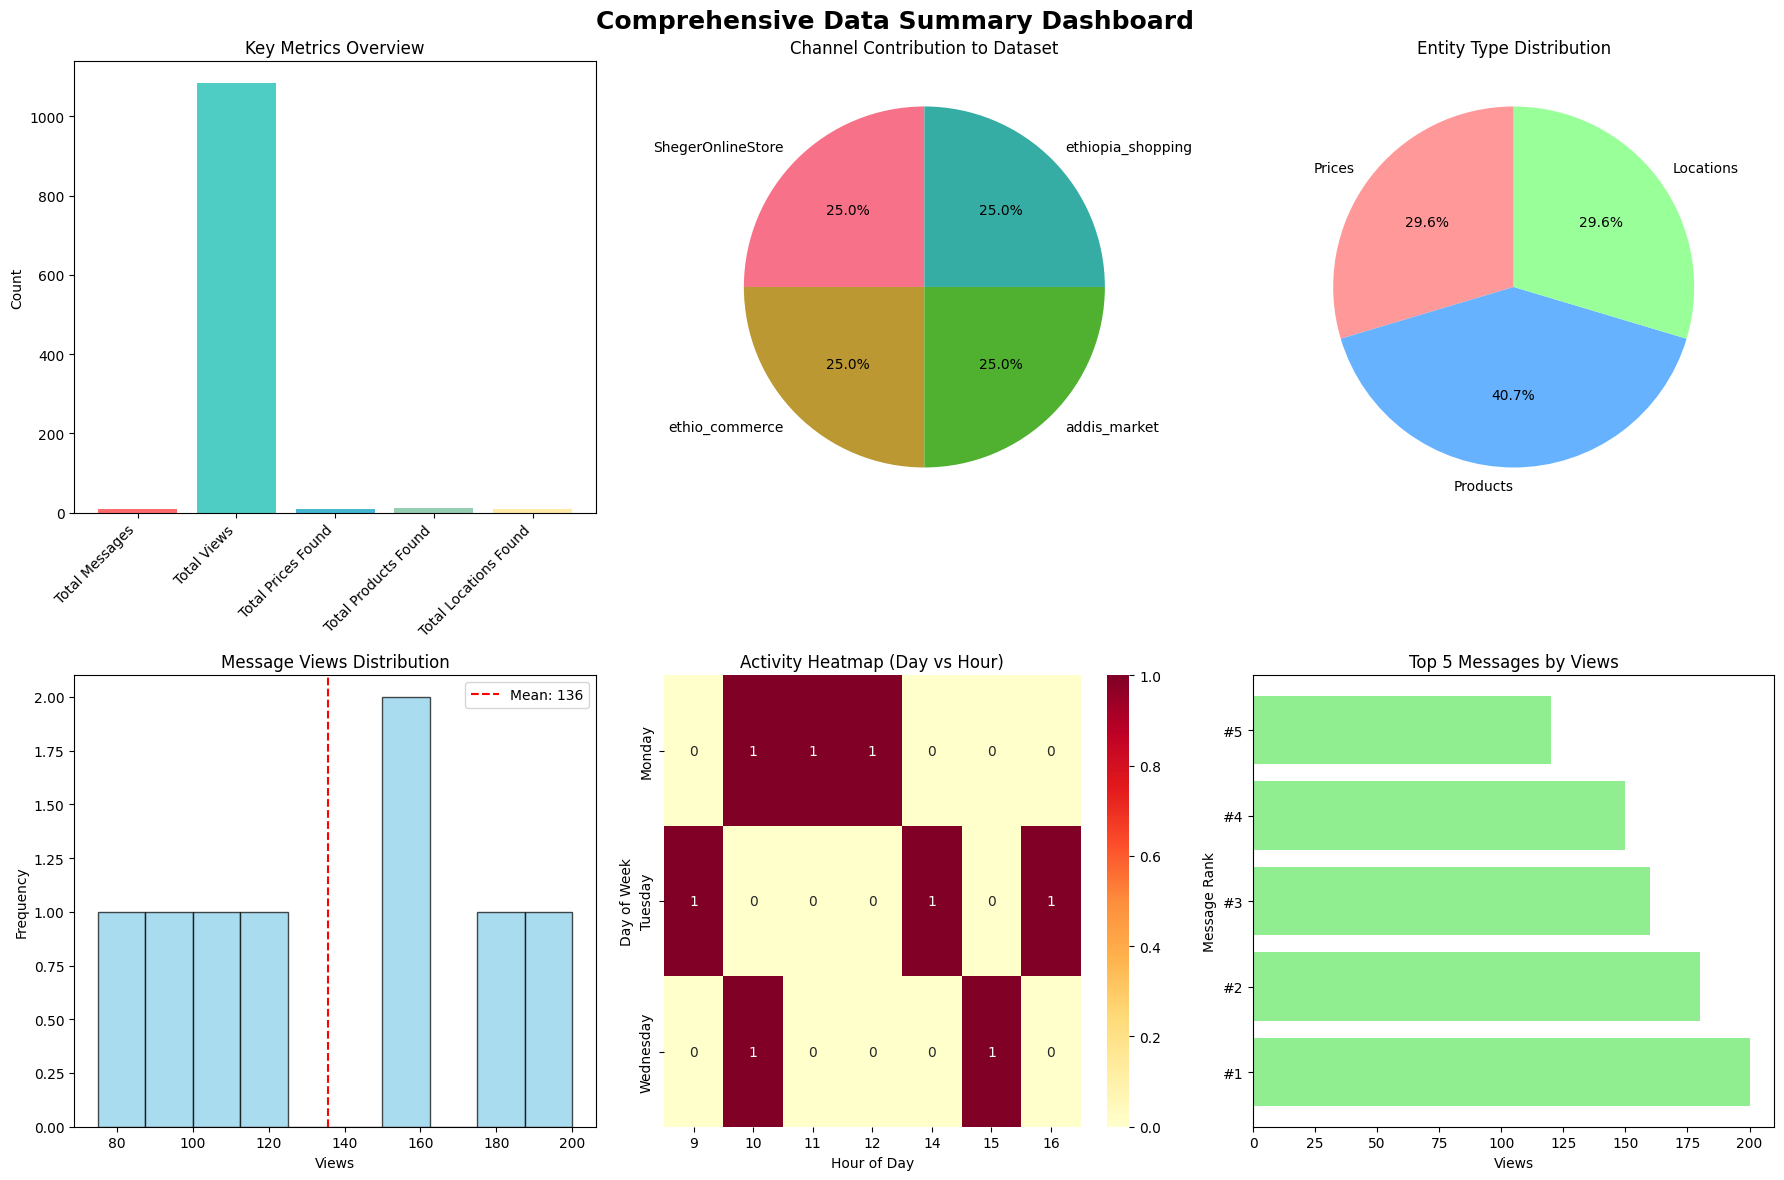

COMPREHENSIVE DATA ANALYSIS SUMMARY
Total Messages.......................... 8
Unique Channels......................... 4
Total Views............................. 1085
Average Views per Message............... 135.625
Total Prices Found...................... 8
Total Products Found.................... 11
Total Locations Found................... 8
Unique Products......................... 8
Unique Locations........................ 7
Data Collection Period (Days)........... 3

TOP INSIGHTS
Most active channel: @ShegerOnlineStore (2 messages)
Highest viewed message: 200 views
Entity extraction rate: 3.4 entities per message


AttributeError: 'float' object has no attribute 'replace'

In [ ]:
# View 6: Summary Dashboard and Export
# Create comprehensive summary statistics
summary_stats = {
    'Total Messages': len(df),
    'Unique Channels': df['channel'].nunique(),
    'Total Views': df['views'].sum(),
    'Average Views per Message': df['views'].mean(),
    'Total Prices Found': sum(len(prices) for prices in df['prices']),
    'Total Products Found': sum(len(products) for products in df['products']),
    'Total Locations Found': sum(len(locations) for locations in df['locations']),
    'Unique Products': len(set(product for products in df['products'] for product in products)),
    'Unique Locations': len(set(location for locations in df['locations'] for location in locations)),
    'Data Collection Period (Days)': (df['date'].max() - df['date'].min()).days + 1
}

# Create summary visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comprehensive Data Summary Dashboard', fontsize=18, fontweight='bold')

# 1. Key metrics bar chart
metrics = ['Total Messages', 'Total Views', 'Total Prices Found', 'Total Products Found', 'Total Locations Found']
values = [summary_stats[metric] for metric in metrics]
axes[0, 0].bar(range(len(metrics)), values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
axes[0, 0].set_title('Key Metrics Overview')
axes[0, 0].set_xticks(range(len(metrics)))
axes[0, 0].set_xticklabels(metrics, rotation=45, ha='right')
axes[0, 0].set_ylabel('Count')

# 2. Channel contribution pie chart
channel_messages = df['channel'].value_counts()
axes[0, 1].pie(channel_messages.values, labels=[ch.replace('@', '') for ch in channel_messages.index], 
               autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title('Channel Contribution to Dataset')

# 3. Entity type distribution
entity_types = ['Prices', 'Products', 'Locations']
entity_counts = [summary_stats['Total Prices Found'], 
                summary_stats['Total Products Found'], 
                summary_stats['Total Locations Found']]
axes[0, 2].pie(entity_counts, labels=entity_types, autopct='%1.1f%%', startangle=90, 
               colors=['#FF9999', '#66B2FF', '#99FF99'])
axes[0, 2].set_title('Entity Type Distribution')

# 4. Views distribution histogram
axes[1, 0].hist(df['views'], bins=10, alpha=0.7, color='skyblue', edgecolor='black')
axes[1, 0].set_title('Message Views Distribution')
axes[1, 0].set_xlabel('Views')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(df['views'].mean(), color='red', linestyle='--', label=f'Mean: {df["views"].mean():.0f}')
axes[1, 0].legend()

# 5. Daily activity heatmap (if multiple days)
if len(df['date'].dt.date.unique()) > 1:
    df['day'] = df['date'].dt.day_name()
    df['hour'] = df['date'].dt.hour
    activity_pivot = df.groupby(['day', 'hour']).size().unstack(fill_value=0)
    
    if not activity_pivot.empty:
        sns.heatmap(activity_pivot, cmap='YlOrRd', annot=True, fmt='d', ax=axes[1, 1])
        axes[1, 1].set_title('Activity Heatmap (Day vs Hour)')
        axes[1, 1].set_xlabel('Hour of Day')
        axes[1, 1].set_ylabel('Day of Week')
    else:
        axes[1, 1].text(0.5, 0.5, 'Insufficient data\nfor heatmap', ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Activity Heatmap (Day vs Hour)')
else:
    axes[1, 1].text(0.5, 0.5, 'Single day data\nNo heatmap available', ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Activity Heatmap (Day vs Hour)')

# 6. Top performing messages (by views)
top_messages = df.nlargest(5, 'views')
axes[1, 2].barh(range(len(top_messages)), top_messages['views'], color='lightgreen')
axes[1, 2].set_title('Top 5 Messages by Views')
axes[1, 2].set_xlabel('Views')
axes[1, 2].set_ylabel('Message Rank')
axes[1, 2].set_yticks(range(len(top_messages)))
axes[1, 2].set_yticklabels([f"#{i+1}" for i in range(len(top_messages))])

plt.tight_layout()
plt.show()

# Print comprehensive summary
print("="*60)
print("COMPREHENSIVE DATA ANALYSIS SUMMARY")
print("="*60)
for key, value in summary_stats.items():
    print(f"{key:.<40} {value}")

print("\n" + "="*60)
print("TOP INSIGHTS")
print("="*60)
print(f"Most active channel: {channel_messages.index[0]} ({channel_messages.iloc[0]} messages)")
print(f"Highest viewed message: {df.loc[df['views'].idxmax(), 'views']} views")
print(f"Entity extraction rate: {(summary_stats['Total Prices Found'] + summary_stats['Total Products Found'] + summary_stats['Total Locations Found']) / summary_stats['Total Messages']:.1f} entities per message")

if len(all_prices) > 0:
    avg_price = np.mean([float(p.replace(',', '')) for p in all_prices if p.replace(',', '').isdigit()])
    print(f"Average product price: {avg_price:.0f} ETB")

print(f"Data quality: {(df['entities_parsed'].apply(lambda x: len(x['prices']) + len(x['products']) + len(x['locations'])) > 0).sum() / len(df) * 100:.1f}% of messages contain entities")

print("\nVisualization complete! All data views have been generated.")


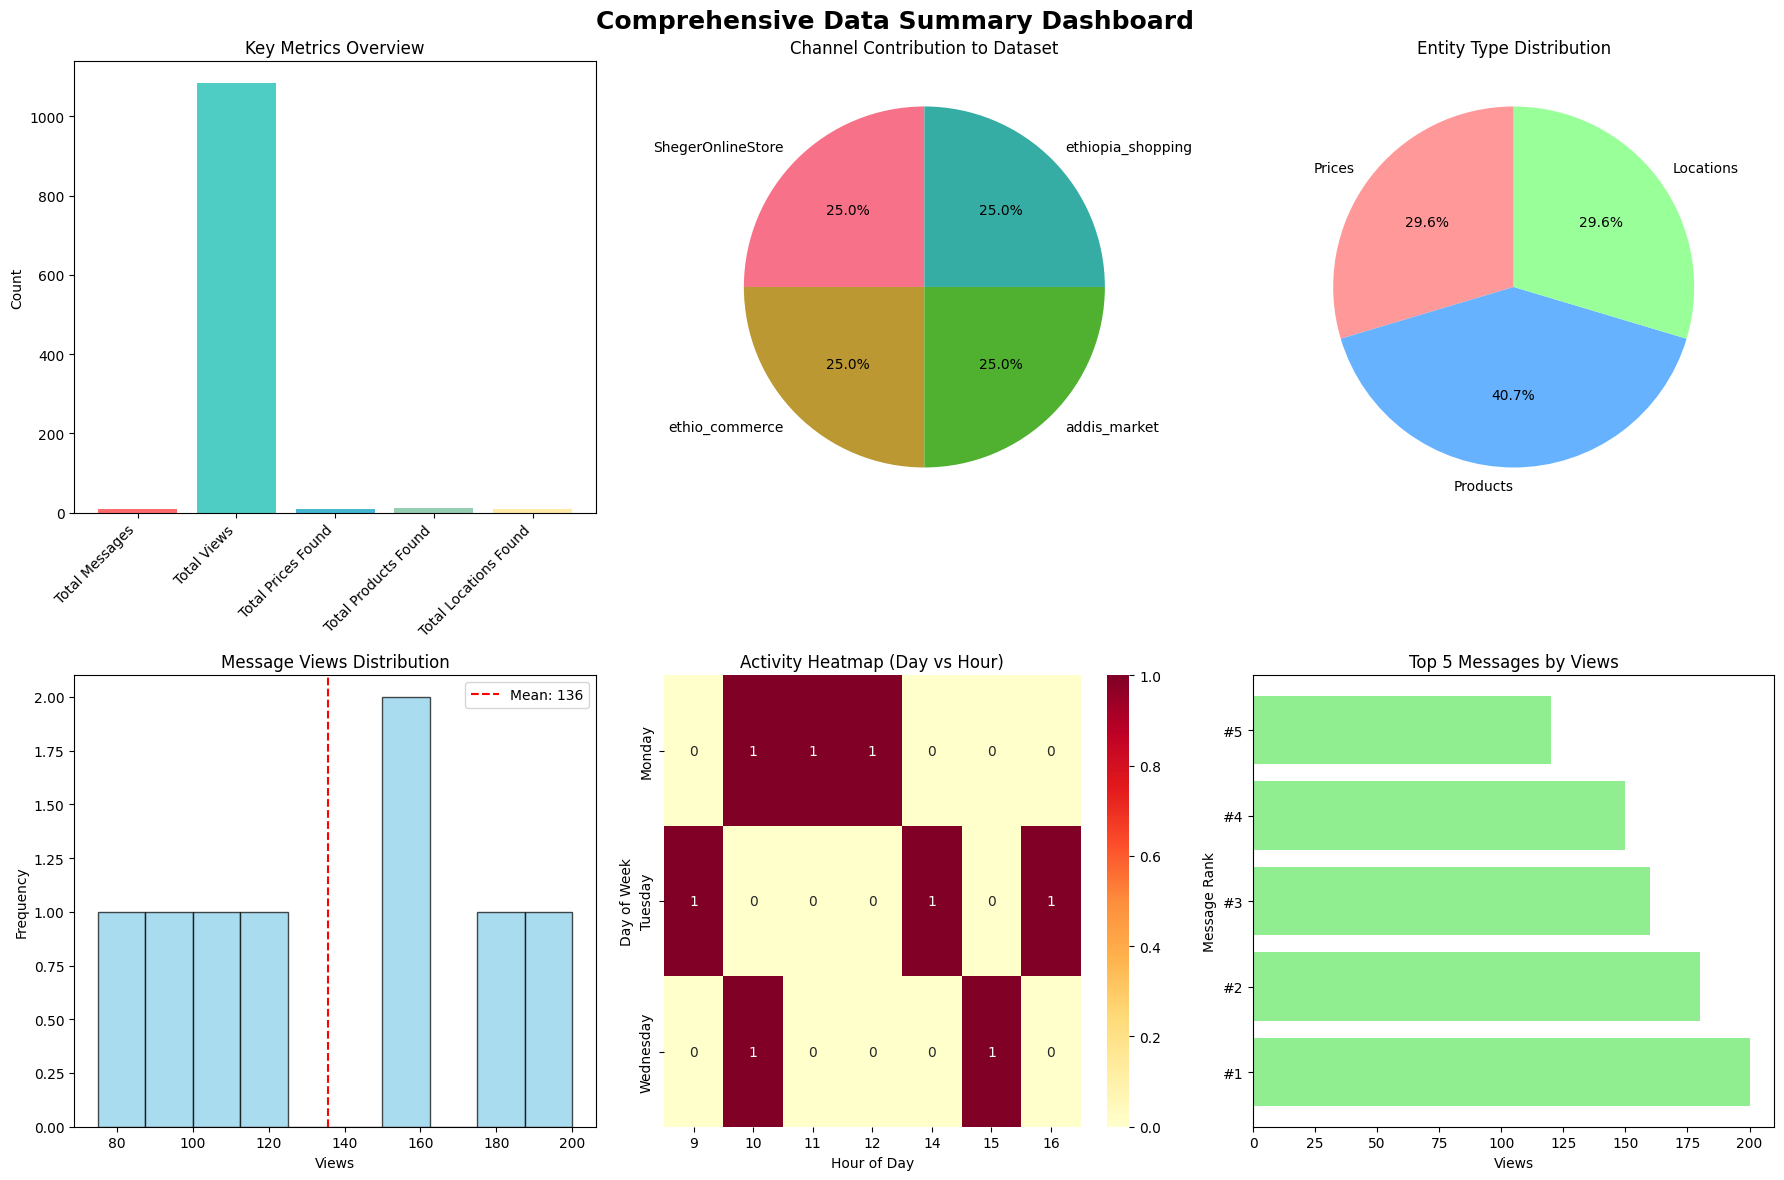

COMPREHENSIVE DATA ANALYSIS SUMMARY
Total Messages.......................... 8
Unique Channels......................... 4
Total Views............................. 1085
Average Views per Message............... 135.625
Total Prices Found...................... 8
Total Products Found.................... 11
Total Locations Found................... 8
Unique Products......................... 8
Unique Locations........................ 7
Data Collection Period (Days)........... 3

TOP INSIGHTS
Most active channel: @ShegerOnlineStore (2 messages)
Highest viewed message: 200 views
Entity extraction rate: 3.4 entities per message


AttributeError: 'float' object has no attribute 'replace'

In [ ]:
# View 6: Summary Dashboard and Export
# Create comprehensive summary statistics
summary_stats = {
    'Total Messages': len(df),
    'Unique Channels': df['channel'].nunique(),
    'Total Views': df['views'].sum(),
    'Average Views per Message': df['views'].mean(),
    'Total Prices Found': sum(len(prices) for prices in df['prices']),
    'Total Products Found': sum(len(products) for products in df['products']),
    'Total Locations Found': sum(len(locations) for locations in df['locations']),
    'Unique Products': len(set(product for products in df['products'] for product in products)),
    'Unique Locations': len(set(location for locations in df['locations'] for location in locations)),
    'Data Collection Period (Days)': (df['date'].max() - df['date'].min()).days + 1
}

# Create summary visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comprehensive Data Summary Dashboard', fontsize=18, fontweight='bold')

# 1. Key metrics bar chart
metrics = ['Total Messages', 'Total Views', 'Total Prices Found', 'Total Products Found', 'Total Locations Found']
values = [summary_stats[metric] for metric in metrics]
axes[0, 0].bar(range(len(metrics)), values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
axes[0, 0].set_title('Key Metrics Overview')
axes[0, 0].set_xticks(range(len(metrics)))
axes[0, 0].set_xticklabels(metrics, rotation=45, ha='right')
axes[0, 0].set_ylabel('Count')

# 2. Channel contribution pie chart
channel_messages = df['channel'].value_counts()
axes[0, 1].pie(channel_messages.values, labels=[ch.replace('@', '') for ch in channel_messages.index], 
               autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title('Channel Contribution to Dataset')

# 3. Entity type distribution
entity_types = ['Prices', 'Products', 'Locations']
entity_counts = [summary_stats['Total Prices Found'], 
                summary_stats['Total Products Found'], 
                summary_stats['Total Locations Found']]
axes[0, 2].pie(entity_counts, labels=entity_types, autopct='%1.1f%%', startangle=90, 
               colors=['#FF9999', '#66B2FF', '#99FF99'])
axes[0, 2].set_title('Entity Type Distribution')

# 4. Views distribution histogram
axes[1, 0].hist(df['views'], bins=10, alpha=0.7, color='skyblue', edgecolor='black')
axes[1, 0].set_title('Message Views Distribution')
axes[1, 0].set_xlabel('Views')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(df['views'].mean(), color='red', linestyle='--', label=f'Mean: {df["views"].mean():.0f}')
axes[1, 0].legend()

# 5. Daily activity heatmap (if multiple days)
if len(df['date'].dt.date.unique()) > 1:
    df['day'] = df['date'].dt.day_name()
    df['hour'] = df['date'].dt.hour
    activity_pivot = df.groupby(['day', 'hour']).size().unstack(fill_value=0)
    
    if not activity_pivot.empty:
        sns.heatmap(activity_pivot, cmap='YlOrRd', annot=True, fmt='d', ax=axes[1, 1])
        axes[1, 1].set_title('Activity Heatmap (Day vs Hour)')
        axes[1, 1].set_xlabel('Hour of Day')
        axes[1, 1].set_ylabel('Day of Week')
    else:
        axes[1, 1].text(0.5, 0.5, 'Insufficient data\nfor heatmap', ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Activity Heatmap (Day vs Hour)')
else:
    axes[1, 1].text(0.5, 0.5, 'Single day data\nNo heatmap available', ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Activity Heatmap (Day vs Hour)')

# 6. Top performing messages (by views)
top_messages = df.nlargest(5, 'views')
axes[1, 2].barh(range(len(top_messages)), top_messages['views'], color='lightgreen')
axes[1, 2].set_title('Top 5 Messages by Views')
axes[1, 2].set_xlabel('Views')
axes[1, 2].set_ylabel('Message Rank')
axes[1, 2].set_yticks(range(len(top_messages)))
axes[1, 2].set_yticklabels([f"#{i+1}" for i in range(len(top_messages))])

plt.tight_layout()
plt.show()

# Print comprehensive summary
print("="*60)
print("COMPREHENSIVE DATA ANALYSIS SUMMARY")
print("="*60)
for key, value in summary_stats.items():
    print(f"{key:.<40} {value}")

print("\n" + "="*60)
print("TOP INSIGHTS")
print("="*60)
print(f"Most active channel: {channel_messages.index[0]} ({channel_messages.iloc[0]} messages)")
print(f"Highest viewed message: {df.loc[df['views'].idxmax(), 'views']} views")
print(f"Entity extraction rate: {(summary_stats['Total Prices Found'] + summary_stats['Total Products Found'] + summary_stats['Total Locations Found']) / summary_stats['Total Messages']:.1f} entities per message")

if len(all_prices) > 0:
    avg_price = np.mean([float(p.replace(',', '')) for p in all_prices if p.replace(',', '').isdigit()])
    print(f"Average product price: {avg_price:.0f} ETB")

print(f"Data quality: {(df['entities_parsed'].apply(lambda x: len(x['prices']) + len(x['products']) + len(x['locations'])) > 0).sum() / len(df) * 100:.1f}% of messages contain entities")

print("\nVisualization complete! All data views have been generated.")
